In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pickle as pkl
from multihist import Histdd

import flamedisx as fd
import os
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import h5py
import multihist as mh
import inference_interface
pdfs = [dict(), dict()] # Stores the generated pdfs in a dictionary.

# Function To Calc Percentiles

In [35]:
def percentile_to_level(array, percentile):
    array = np.sort(np.ravel(array))[::-1]
    norm = np.sum(array)
    percentiles = np.cumsum(array) / norm * 100
    levels = array    
    return np.interp(percentile, percentiles, levels)

# Functions to make percentile contours

In [36]:
def plot_hist_all(hist, color='k', label="label", **kwargs):
    contour_handles = []
    xx, yy = np.meshgrid(*hist.bin_centers())
    zz = np.array(hist.histogram).T
    for percentile, ls in zip([68, 95], ['solid', 'dashdot']):  # Confidence levels
        level = percentile_to_level(zz, percentile)
        c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)
        # Append custom legend handles for contours
        contour_handles.append(plt.Line2D([], [], color=color, linestyle=ls, label=f"{label} ({percentile} percentile contour)"))
    return contour_handles

# Same function as above, but only calcs the 68 percentile contour 

def plot_hist_68(hist, color='k', label="label", **kwargs):
    contour_handles = []
    xx, yy = np.meshgrid(*hist.bin_centers())
    zz = np.array(hist.histogram).T
    for percentile, ls in zip([68], ['solid']):  # Confidence levels
        level = percentile_to_level(zz, percentile)
        c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)
        # Append custom legend handles for contours
        contour_handles.append(plt.Line2D([], [], color=color, linestyle=ls, label=f"{label} ({percentile} percentile contour)"))
    return contour_handles

# Same function as above, but only calcs the 95 percentile contour 

def plot_hist_95(hist, color='k', label="label", **kwargs):
    contour_handles = []
    xx, yy = np.meshgrid(*hist.bin_centers())
    zz = np.array(hist.histogram).T
    for percentile, ls in zip([95], [ 'dashdot']):  # Confidence levels
        level = percentile_to_level(zz, percentile)
        c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)
        # Append custom legend handles for contours
        contour_handles.append(plt.Line2D([], [], color=color, linestyle=ls, label=f"{label} ({percentile} percentile contour)"))
    return contour_handles

# Gaussian function

In [37]:
# to be used later on 1d Projections of cS1 and cS2 for background and signal templates.
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

## ROI for templates

In [38]:
configuration='60t' #Set your detector config here '60t' or '80t'
#drift_field=290. #Drift field in V/cm for 80T
drift_field=240. #Drift field in V/cm for 60T and 40T

# Source configs
xlzd_source = fd.xlzd.XLZDERSource(configuration=configuration)


# The thresholds are set in xlzd.ini, if you make change to ROI, make sure you change the thresholds (cS1-cS2 space) accordingly in the AC maker file, ideally we will incorporate this while merging AC workflow into Flamedisx
cS1_min = xlzd_source.cS1_min
cS1_max = xlzd_source.cS1_max
log10_cS2_min = xlzd_source.log10_cS2_min
log10_cS2_max = xlzd_source.log10_cS2_max
print(cS1_max)

300.0


/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


## Background sources

In [39]:
SolarER = fd.xlzd.XLZDvERSource(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


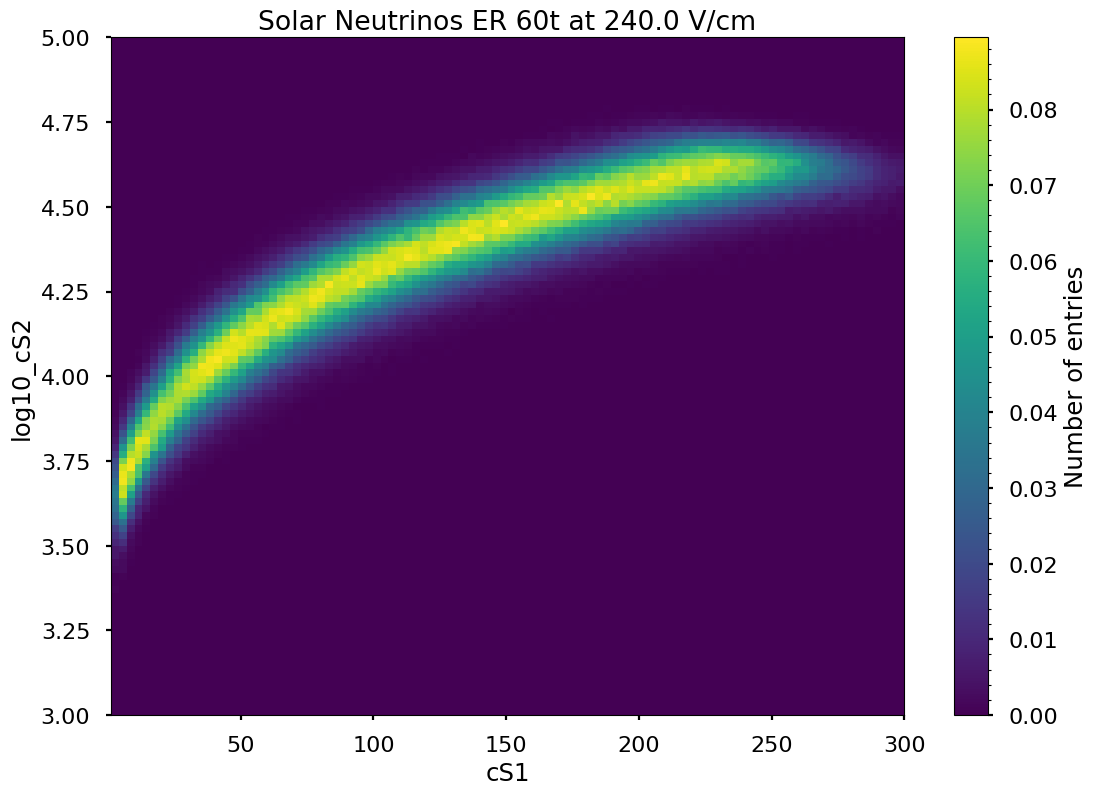

In [40]:
SolarER_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

SolarER_data = SolarER.simulate(int(1e6)) 


SolarER_hist.add(SolarER_data['cs1'], np.log10(SolarER_data['cs2']))

SolarER_mu = SolarER.estimate_mu(n_trials=int(1e6))


SolarER_hist.histogram = SolarER_hist.histogram / SolarER_hist.n * SolarER_mu 

SolarER_hist.plot()
plt.title(f"Solar Neutrinos ER {SolarER.configuration} at {SolarER.drift_field} V/cm")

pdfs[0]['SolarER'] = SolarER_hist

In [41]:
Xe136 = fd.xlzd.XLZDXe136Source(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


85.85065918240356


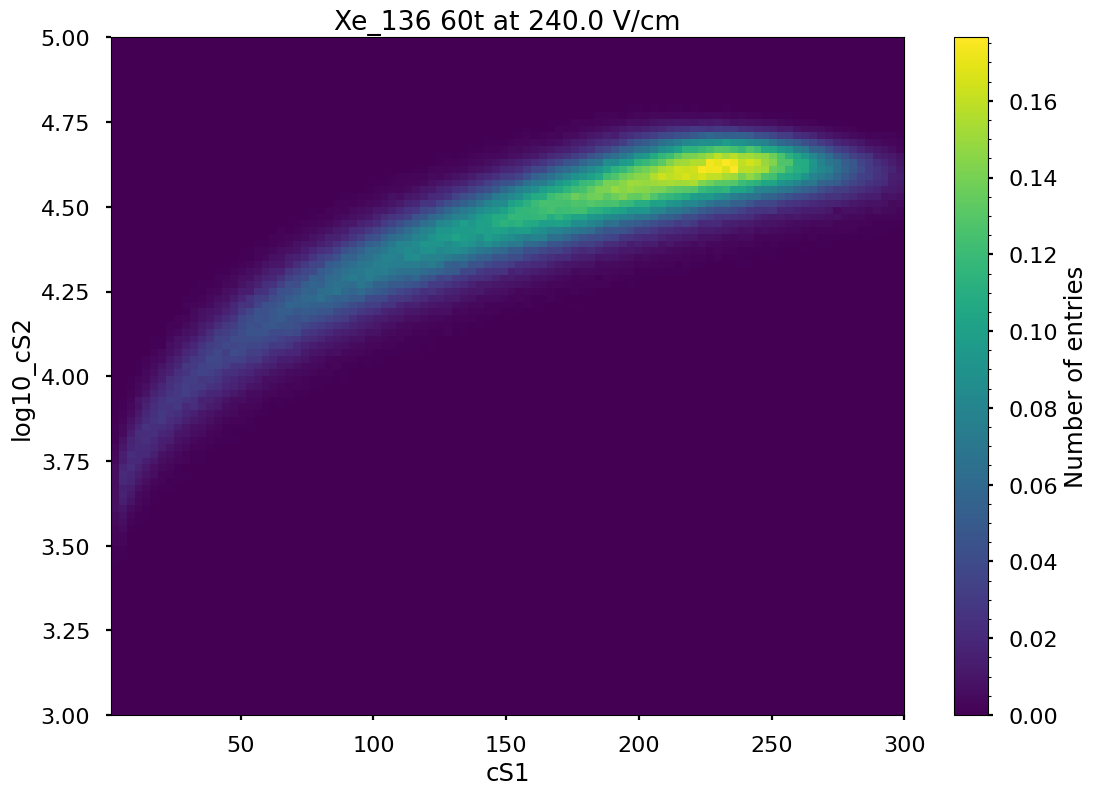

In [42]:
Xe136_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Xe136_data = Xe136.simulate(int(1e6))

Xe136_hist.add(Xe136_data['cs1'], np.log10(Xe136_data['cs2']))

Xe136_mu = Xe136.estimate_mu(n_trials=int(1e6))
Xe136_hist.histogram = Xe136_hist.histogram / Xe136_hist.n * Xe136_mu


Xe136_hist.plot()
plt.title(f"Xe_136 {Xe136.configuration} at {Xe136.drift_field} V/cm")

pdfs[0]['Xe136'] = Xe136_hist
print(Xe136_hist.n)


In [43]:
Pb214 = fd.xlzd.XLZDPb214Source(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


Counts from simulation 968959.0
11.054581124067306


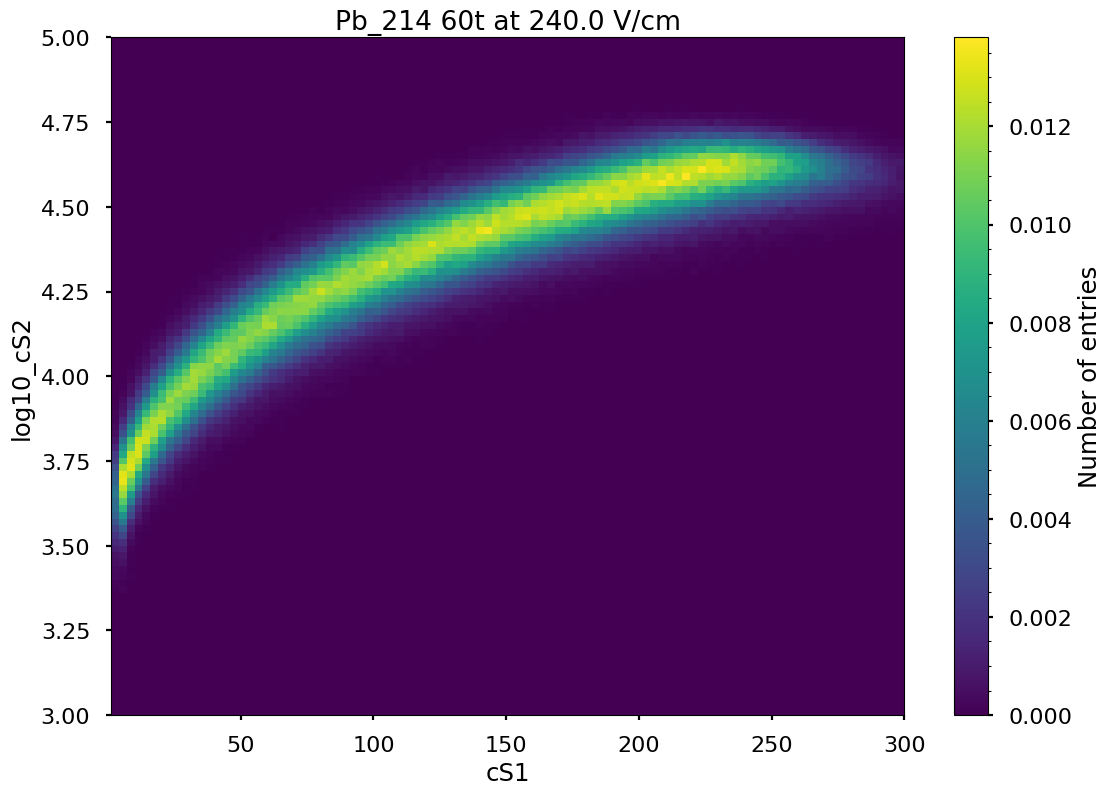

In [44]:
Pb214_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Pb214_data = Pb214.simulate(int(1e6))

Pb214_hist.add(Pb214_data['cs1'], np.log10(Pb214_data['cs2']))

Pb214_mu = Pb214.estimate_mu(n_trials=int(1e6))
print("Counts from simulation",Pb214_hist.n)
Pb214_hist.histogram = Pb214_hist.histogram / Pb214_hist.n * Pb214_mu
plt.title(f"Pb_214 {Pb214.configuration} at {Pb214.drift_field} V/cm")
Pb214_hist.plot()

pdfs[0]['Pb214'] = Pb214_hist
print(Pb214_hist.n)

In [45]:
Kr85 = fd.xlzd.XLZDKr85Source(configuration=configuration,
                               drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                               elife_ns=10000e3, g1=0.27)

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


befire 969187.0
after 45.48859910100173


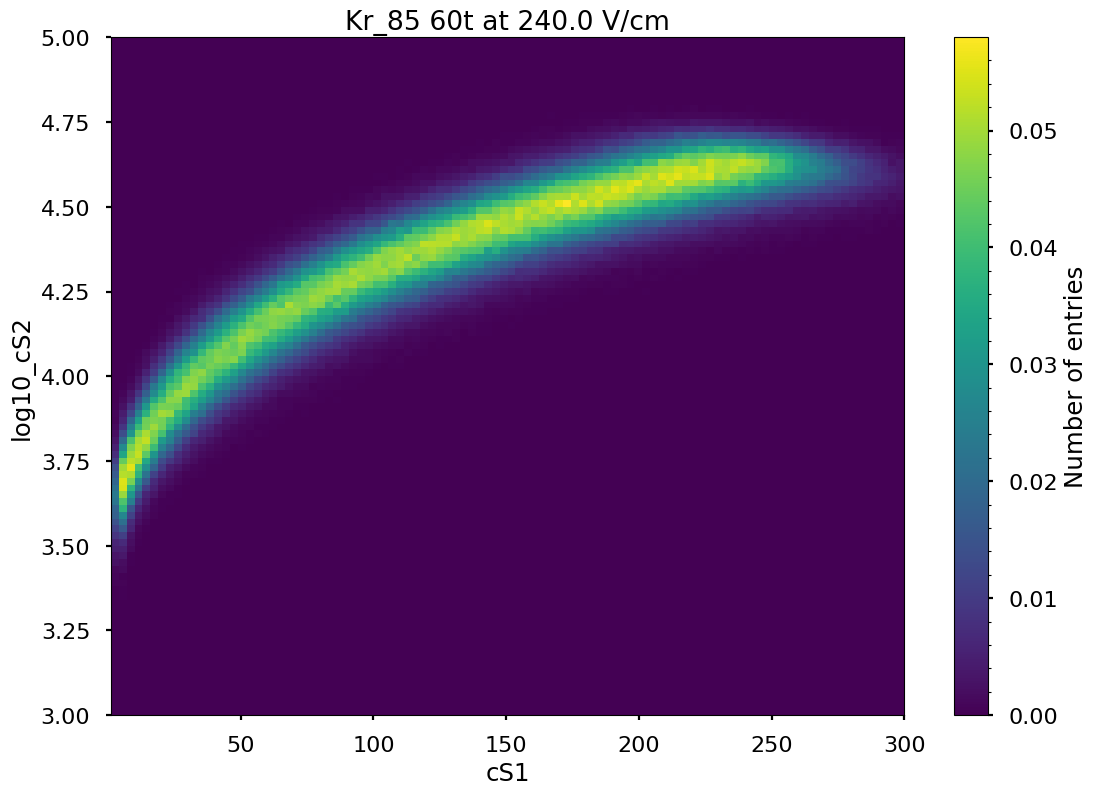

In [46]:
Kr85_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Kr85_data = Kr85.simulate(int(1e6))

Kr85_hist.add(Kr85_data['cs1'], np.log10(Kr85_data['cs2']))

Kr85_mu = Kr85.estimate_mu(n_trials=int(1e6))
print("befire",Kr85_hist.n)
Kr85_hist.histogram = Kr85_hist.histogram / Kr85_hist.n * Kr85_mu
print("after",Kr85_hist.n)
plt.title(f"Kr_85 {Kr85.configuration} at {Kr85.drift_field} V/cm")
Kr85_hist.plot()

pdfs[0]['Kr85'] = Kr85_hist

In [47]:
CEvNS_solar = fd.xlzd.XLZDvNRSolarSource(configuration=configuration,
                                         drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                         elife_ns=10000e3, g1=0.27)

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


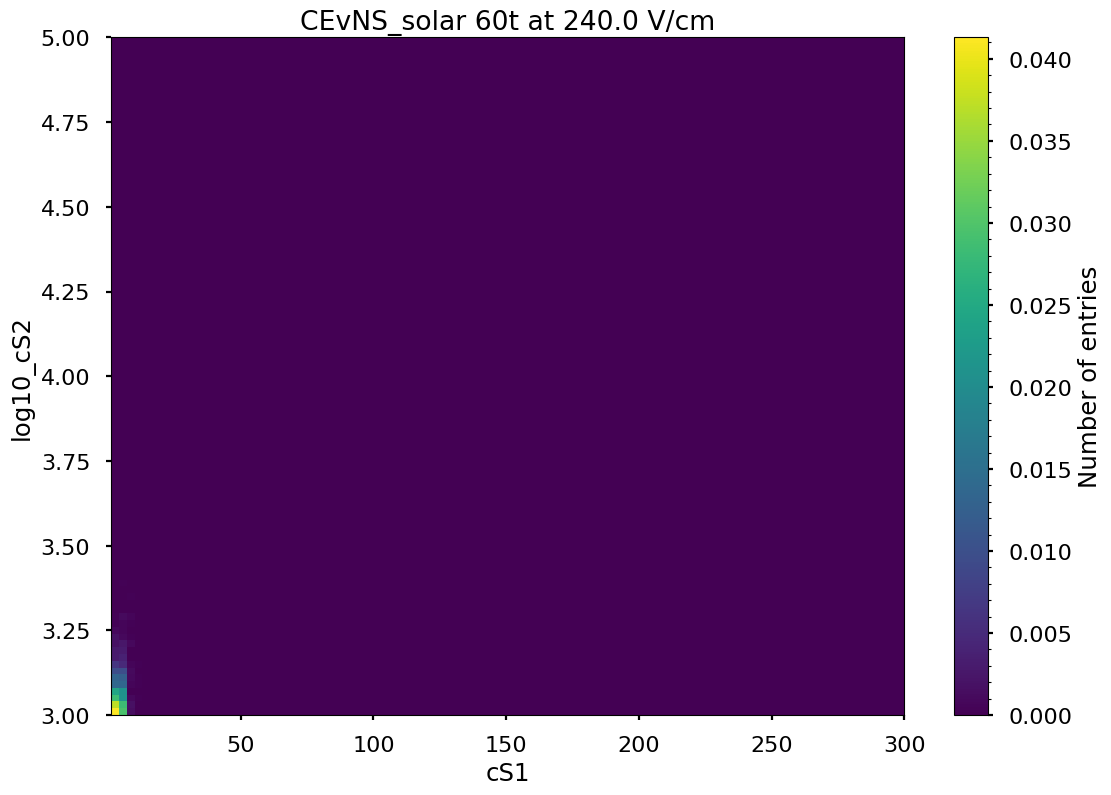

In [48]:
CEvNS_solar_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

CEvNS_solar_data = CEvNS_solar.simulate(int(1e6))

CEvNS_solar_hist.add(CEvNS_solar_data['cs1'], np.log10(CEvNS_solar_data['cs2']))

CEvNS_solar_mu = CEvNS_solar.estimate_mu(n_trials=int(1e6))
CEvNS_solar_hist.histogram = CEvNS_solar_hist.histogram / CEvNS_solar_hist.n * CEvNS_solar_mu

CEvNS_solar_hist.plot()
plt.title(f"CEvNS_solar {CEvNS_solar.configuration} at {CEvNS_solar.drift_field} V/cm")

pdfs[0]['CEvNS_solar'] = CEvNS_solar_hist

In [49]:
CEvNS_other = fd.xlzd.XLZDvNROtherSource(configuration=configuration,
                                         drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                         elife_ns=10000e3, g1=0.27)


/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


CEvNS_other_mu  0.049038276459574696
before normalisation counts 692319.0
After normalisation counts,before scaling 1.0
after scaling 0.04903827645957468


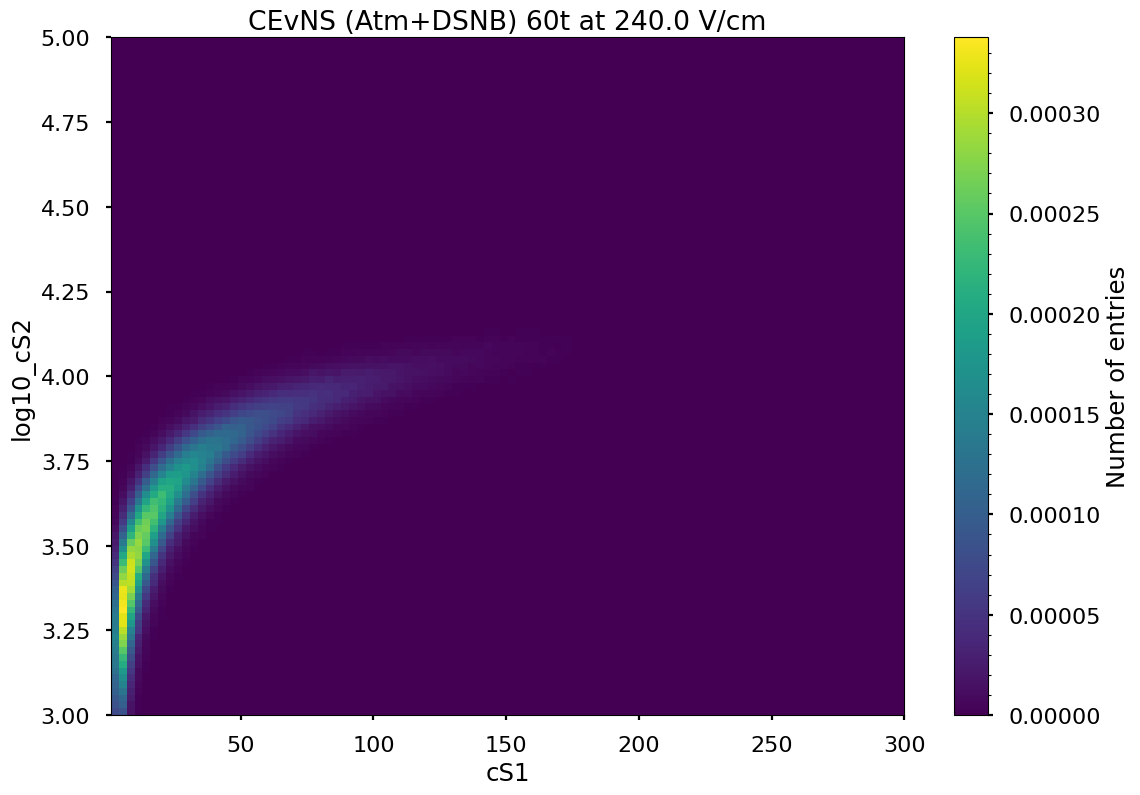

In [50]:
CEvNS_other_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])
CEvNS_other_data = CEvNS_other.simulate(int(1e6))
CEvNS_other_hist.add(CEvNS_other_data['cs1'], np.log10(CEvNS_other_data['cs2']))
CEvNS_other_mu = CEvNS_other.estimate_mu(n_trials=int(1e6))
print("CEvNS_other_mu ",CEvNS_other_mu )

print("before normalisation counts", CEvNS_other_hist.n)

CEvNS_other_hist.histogram = CEvNS_other_hist.histogram / CEvNS_other_hist.n
print("After normalisation counts,before scaling", CEvNS_other_hist.n)

CEvNS_other_hist.histogram = CEvNS_other_hist.histogram / CEvNS_other_hist.n * CEvNS_other_mu
print("after scaling",CEvNS_other_hist.n)
CEvNS_other_hist.plot()
plt.title(f"CEvNS (Atm+DSNB) {CEvNS_other.configuration} at {CEvNS_other.drift_field} V/cm")


pdfs[0]['CEvNS_other'] = CEvNS_other_hist


# Importing AC template

AC workflow is yet to be merged into Flamedisx, so currently we are importing the template from the AC workflow 
in the following directory : ../AC_background

Use this notebook to make the AC template : ...XLZD_ACTemplateMaker_30Jan2025_final.ipynb


In [51]:


# Define AC template file path here :
file_path = "/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/XLZD_60.0T_3folds_240Vcm_v0.1.0_Final/AC_XLZDTemplate_3fold.hdf"
 
#file_path = "/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/XLZD_60.0T_4folds_240Vcm_v0.1.0_Final/AC_XLZDTemplate_4fold.hdf"

#file_path="/Users/amirr/Desktop/Flame/FlameFitSimple/analyses/wimp_sensitivity/AC_background/XLZD_80.0T_4folds_290Vcm_v0.1.0_Final/AC_XLZDTemplate_4fold.hdf"
AC_temp=inference_interface.template_to_multihist(file_path)["%i"]

print(AC_temp.n)
pdfs[0]['AC_temp'] = AC_temp
print(type(AC_temp))

11035.925739191636
<class 'multihist.Histdd'>


# Plotting the AC template with Projections

3fold


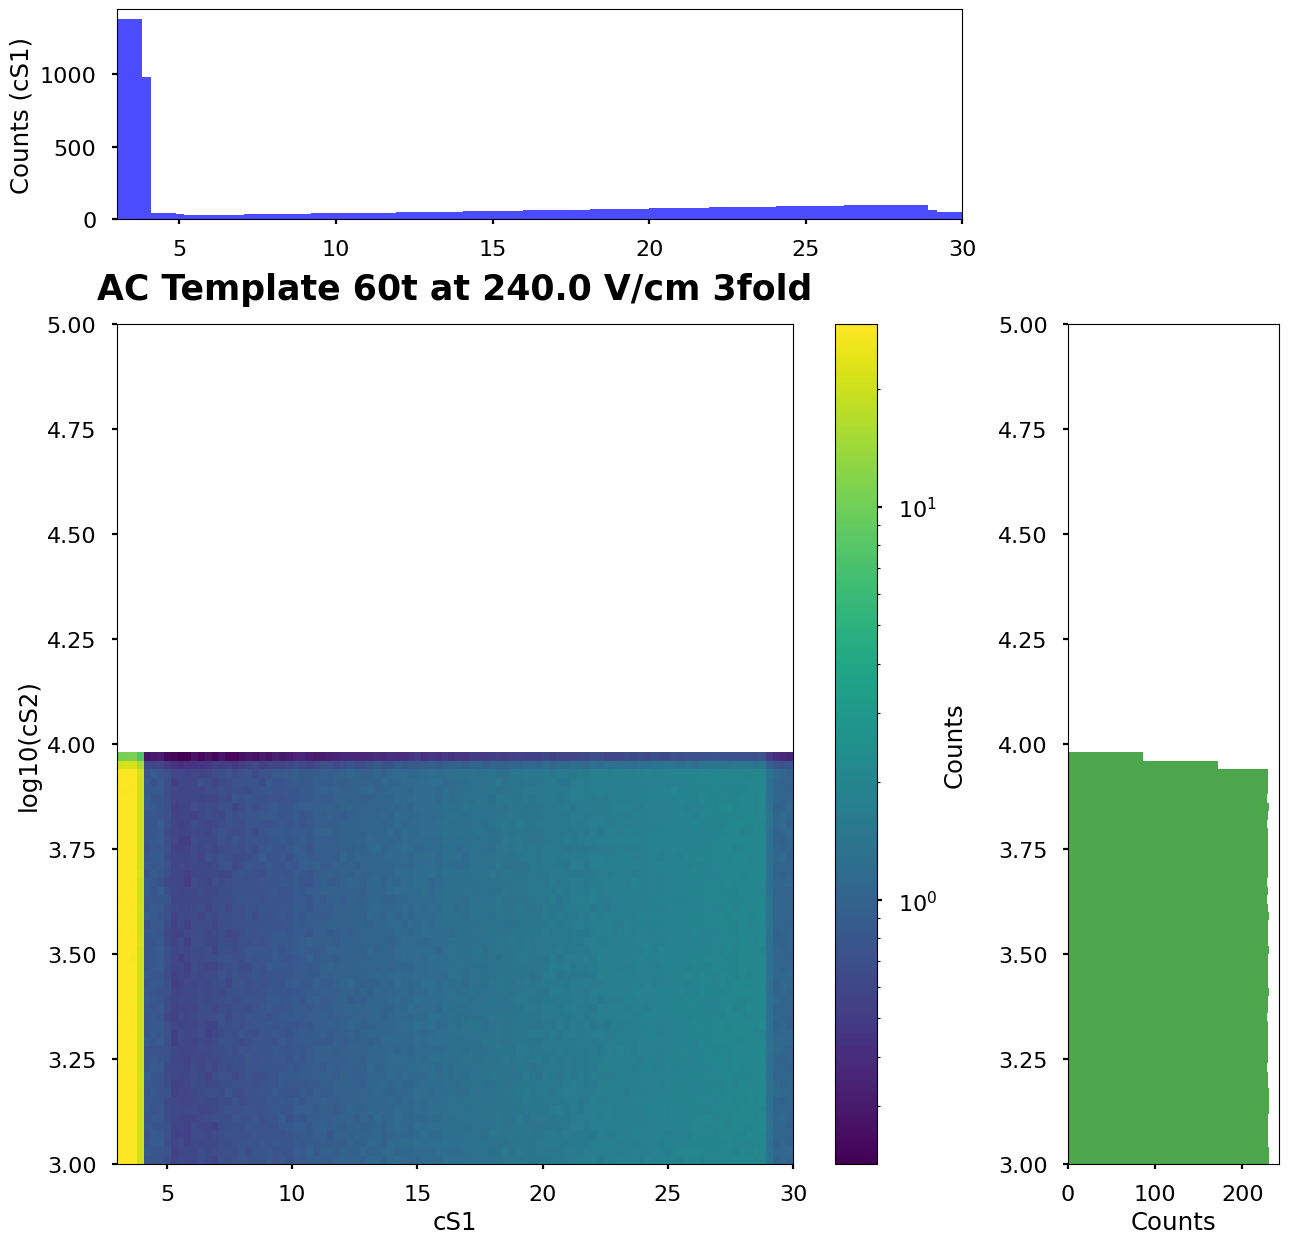

In [52]:
import re

match = re.search(r"_(\d+fold)", file_path)
if match:
    extracted_text = match.group(1)
    print(extracted_text)  # Output: nfold

# Assume AC_temp is already defined
bin_edges_cS1 = AC_temp.bin_edges[0]  # Bin edges for 'cS1'
bin_edges_cS2 = AC_temp.bin_edges[1]  # Bin edges for 'log10_cS2'

# Calculate bin centers
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2

# Get histogram counts
counts_cS1 = AC_temp.histogram.sum(axis=1) # Sum over 'log10_cS2'
counts_cS2 = AC_temp.histogram.sum(axis=0) # Sum over 'cS1'

# Main 2D histogram (joint distribution)
main_histogram = AC_temp.histogram.T  # Transpose for proper alignment

# Create a figure with gridspec layout
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(4, 4, wspace=.5, hspace=.5)

# Main plot (joint distribution)
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram,cmap='viridis',norm=mcolors.LogNorm())
ax_main.set_xlabel('cS1')
ax_main.set_ylabel('log10(cS2)')
fig.colorbar(pcm, ax=ax_main, label='Counts')

ax_main.set_title(f"AC Template {SolarER.configuration} at {SolarER.drift_field} V/cm {extracted_text}", y=1.02, fontweight="bold",fontsize=25)
# Top histogram (cS1)
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.bar(bin_centers_cS1, counts_cS1, width=np.diff(bin_edges_cS1), align='center', color='blue', alpha=0.7)
ax_top.set_ylabel('Counts (cS1)')
ax_top.tick_params(axis='x', labelbottom=True)

# Right histogram (cS2)
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.barh(bin_centers_cS2, counts_cS2, height=np.diff(bin_edges_cS2), align='center', color='green', alpha=0.7)
ax_right.set_xlabel('Counts')
ax_right.tick_params(axis='y', labelleft=True)
# Show the plot
plt.show()


# Function to quantify the band overlap

In [53]:
"""
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

# Main steps for overlap quantification
def quantify_overlap(ER_hist, NR_hist):
    # Generate grid and histograms for ER and NR
    xx_er, yy_er = np.meshgrid(*ER_hist.bin_centers())
    zz_er = np.array(ER_hist.histogram).T

    xx_nr, yy_nr = np.meshgrid(*NR_hist.bin_centers())
    zz_nr = np.array(NR_hist.histogram).T

    # Calculate 95th percentile contours
    er_95_level = percentile_to_level(zz_er, 95)
    nr_95_level = percentile_to_level(zz_nr, 95)

    # Get contour polygons
    er_contour = plt.contour(xx_er, yy_er, zz_er, levels=[er_95_level])
    nr_contour = plt.contour(xx_nr, yy_nr, zz_nr, levels=[nr_95_level])

    def contour_to_polygon(contour):
       
        paths = contour.collections[0].get_paths()
        polygons = []
        for path in paths:
            v = path.vertices
            polygons.append(Polygon(v))
        return unary_union(polygons)  # Combine into a single polygon if multiple

    er_polygon = contour_to_polygon(er_contour)
    nr_polygon = contour_to_polygon(nr_contour)
    
    #er_polygon = er_polygon.simplify(0.5)  # Adjust tolerance as needed
    #nr_polygon = nr_polygon.simplify(0.5)


    # Find overlap region
    # Validate and fix polygons
    if not er_polygon.is_valid:
        print("Fixing ER Polygon...")
        er_polygon = er_polygon.buffer(0)

    if not nr_polygon.is_valid:
        print("Fixing NR Polygon...")
        nr_polygon = nr_polygon.buffer(0)

    # Simplify polygons 
    er_polygon = er_polygon.simplify(0.01, preserve_topology=True)
    nr_polygon = nr_polygon.simplify(0.01, preserve_topology=True)

    # Attempt intersection
    try:
        if er_polygon.is_valid and nr_polygon.is_valid:
            overlap_region = er_polygon.intersection(nr_polygon)
            if overlap_region.is_empty:
                print("No overlap region found.")
        else:
            print("Skipping intersection due to invalid geometries.")
            overlap_region = None
    except Exception as e:
        print(f"Error during intersection: {e}")
        overlap_region = None

    #overlap_region = er_polygon.intersection(nr_polygon)
    #overlap_region = nr_polygon.intersection(er_polygon)
    # Count events in the overlap region
    er_events = np.column_stack((xx_er.ravel(), yy_er.ravel()))
    er_events_in_overlap = sum(overlap_region.contains(Point(x, y)) for x, y in er_events)

    nr_events = np.column_stack((xx_nr.ravel(), yy_nr.ravel()))
    nr_events_in_overlap = sum(overlap_region.contains(Point(x, y)) for x, y in nr_events)

    # Calculate ER leakage percentage
    total_er_events = len(er_events)
    print('total_er_events',total_er_events)
    er_leakage = er_events_in_overlap / total_er_events * 100
    print("er_events_in_overlap",er_events_in_overlap)
    print(f"ER Leakage: {er_leakage:.2f}%")
    
    total_nr_events = len(nr_events)
    nr_leakage = nr_events_in_overlap / total_nr_events * 100

    print(f"NR Leakage: {nr_leakage:.2f}%")
    return overlap_region, nr_leakage

"""

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom shapely.geometry import Polygon, Point\nfrom shapely.ops import unary_union\n\n# Main steps for overlap quantification\ndef quantify_overlap(ER_hist, NR_hist):\n    # Generate grid and histograms for ER and NR\n    xx_er, yy_er = np.meshgrid(*ER_hist.bin_centers())\n    zz_er = np.array(ER_hist.histogram).T\n\n    xx_nr, yy_nr = np.meshgrid(*NR_hist.bin_centers())\n    zz_nr = np.array(NR_hist.histogram).T\n\n    # Calculate 95th percentile contours\n    er_95_level = percentile_to_level(zz_er, 95)\n    nr_95_level = percentile_to_level(zz_nr, 95)\n\n    # Get contour polygons\n    er_contour = plt.contour(xx_er, yy_er, zz_er, levels=[er_95_level])\n    nr_contour = plt.contour(xx_nr, yy_nr, zz_nr, levels=[nr_95_level])\n\n    def contour_to_polygon(contour):\n       \n        paths = contour.collections[0].get_paths()\n        polygons = []\n        for path in paths:\n            v = path.vertices\n            polygons.appe

# ER/NR distribution 

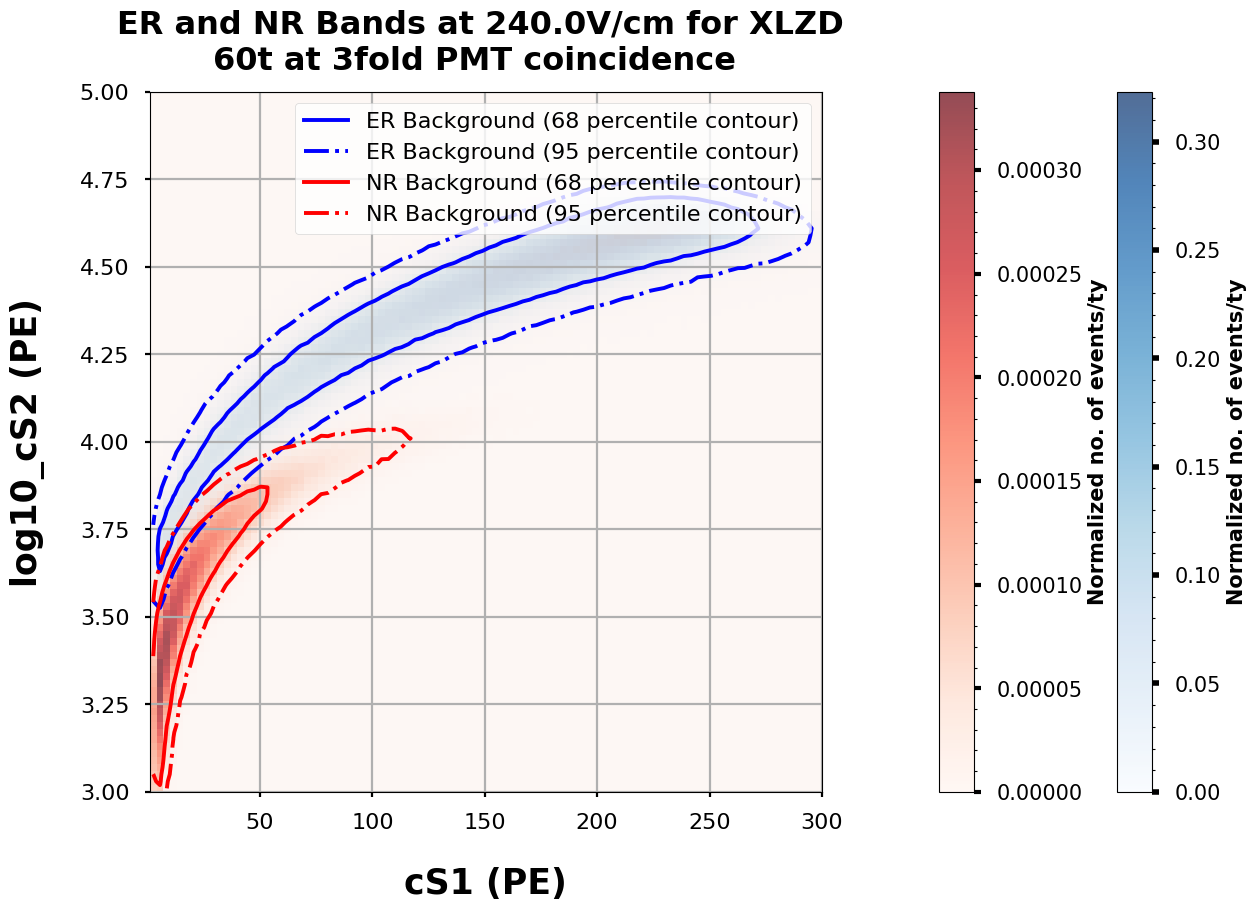

In [54]:
import matplotlib.pyplot as plt

Solar_ER = pdfs[0]["SolarER"]
Xe_136 = pdfs[0]["Xe136"]
Pb_214 = pdfs[0]["Pb214"]
Kr_85 = pdfs[0]["Kr85"]
CEvNS_solar = pdfs[0]["CEvNS_solar"]
CEvNS_other = pdfs[0]["CEvNS_other"]

ER_hist = Solar_ER + Xe_136 + Pb_214 + Kr_85  
NR_hist =  CEvNS_other#+CEvNS_solar

plt.figure(figsize=(15, 14))
plt.style.use('seaborn-v0_8-poster')

# Plot ER histogram and get legend handles
er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
im_er = ER_hist.plot(cmap='Blues', colorbar=True, alpha=0.7, cblabel="Normalized no. of events/ty")
plt.subplots_adjust(left=0.15, right=0.85, bottom=0.35, top=0.85)
# Extract colorbar for ER
cbar_er = im_er[0].colorbar  
cbar_er.ax.yaxis.label.set_size(15)  
cbar_er.ax.yaxis.label.set_weight("bold")  
cbar_er.ax.tick_params(axis='both', labelsize=15, width=4, length=5)
cbar_er.ax.yaxis.get_offset_text().set_size(15)  
cbar_er.ax.yaxis.get_offset_text().set_weight("bold")

# Adjust ER colorbar position
cbar_er.ax.set_position([
    cbar_er.ax.get_position().x0 + 0.05,  
    cbar_er.ax.get_position().y0,
    cbar_er.ax.get_position().width,
    cbar_er.ax.get_position().height
])

# Plot NR histogram and get legend handles
nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")
im_nr = NR_hist.plot(cmap='Reds', colorbar=True, alpha=0.7, cblabel="Normalized no. of events/ty")
#plt.subplots_adjust(left=0.35, right=0.85, bottom=0.35, top=0.85)
# Extract colorbar for NR
cbar_nr = im_nr[0].colorbar  
cbar_nr.ax.yaxis.label.set_size(15)  
cbar_nr.ax.yaxis.label.set_weight("bold")  
cbar_nr.ax.tick_params(axis='both', labelsize=15, width=3, length=5)
cbar_nr.ax.yaxis.get_offset_text().set_size(15)  
cbar_nr.ax.yaxis.get_offset_text().set_weight("bold")

# Adjust NR colorbar position
cbar_nr.ax.set_position([
    cbar_nr.ax.get_position().x0 + 0.05,  
    cbar_nr.ax.get_position().y0,
    cbar_nr.ax.get_position().width,
    cbar_nr.ax.get_position().height
])

# Combine legend handles and add a single legend
all_handles = er_handles + nr_handles
plt.legend(handles=all_handles)
plt.xlabel("cS1 (PE)", fontsize=25, fontweight="bold", labelpad=25)
plt.ylabel("log10_cS2 (PE)", fontsize=25, fontweight="bold", labelpad=25)
# Add plot title
plt.title(f"ER and NR Bands at {SolarER.drift_field}V/cm for XLZD \n{SolarER.configuration} at {extracted_text} PMT coincidence  ",
          fontweight="bold", fontsize=23, y=1.02)

plt.grid()
plt.show()


# Visualising the band overlap

In [55]:
"""
# Example usage (replace ER_hist and NR_hist with your histogram objects)
overlap_region, er_leakage = quantify_overlap(ER_hist, NR_hist)

# Visualization
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(15, 15))

# Plot ER histogram and get legend handles
er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
ER_hist.plot(cmap='Blues', alpha=0.7)

# Plot NR histogram and get legend handles
nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")
NR_hist.plot(cmap='Reds', alpha=0.7)

# Combine legend handles
all_handles = er_handles + nr_handles

# Plot overlap region
if overlap_region.is_empty:
    print("No overlap found.")
else:
    x, y = overlap_region.exterior.xy
    ax.fill(x, y, color='green', alpha=0.5, 
            label=f"Overlap Region (Events: {er_leakage:.2f})")
    overlap_handle = plt.Line2D([], [], color='green', alpha=0.5, 
                                linestyle='solid', label=f"Percentage of ER events in overlap region ({er_leakage:.2f} percent)")
    all_handles.append(overlap_handle)

# Add the legend to the plot
plt.legend(handles=all_handles)

plt.grid()
plt.title("ER and NR Backgrounds with Overlap Region at 240V/cm for 60t_140ty",fontweight="bold",fontsize=15)
plt.show()
"""

'\n# Example usage (replace ER_hist and NR_hist with your histogram objects)\noverlap_region, er_leakage = quantify_overlap(ER_hist, NR_hist)\n\n# Visualization\nplt.style.use(\'seaborn-v0_8-poster\')\nfig, ax = plt.subplots(figsize=(15, 15))\n\n# Plot ER histogram and get legend handles\ner_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")\nER_hist.plot(cmap=\'Blues\', alpha=0.7)\n\n# Plot NR histogram and get legend handles\nnr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")\nNR_hist.plot(cmap=\'Reds\', alpha=0.7)\n\n# Combine legend handles\nall_handles = er_handles + nr_handles\n\n# Plot overlap region\nif overlap_region.is_empty:\n    print("No overlap found.")\nelse:\n    x, y = overlap_region.exterior.xy\n    ax.fill(x, y, color=\'green\', alpha=0.5, \n            label=f"Overlap Region (Events: {er_leakage:.2f})")\n    overlap_handle = plt.Line2D([], [], color=\'green\', alpha=0.5, \n                                linestyle=\'solid\', l

# All Material and Particle BGS Templates + NR/ER Bands 

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_1671/4106614338.py:29: SyntaxWarning: invalid escape sequence '\m'
  "CEvNS_Solar_Neutrinos \n($\mathbf{^8B}$ + HEP)": {"hist": CEvNS_solar_hist,"source": CEvNS_solar },
/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.

ER_Solar_neutrinos 
(PP + $^7$Be + CNO)
Xe136
Pb214
Kr85
CEvNS_Solar_Neutrinos 
($\mathbf{^8B}$ + HEP)
CEvNS_Neutrinos 
 (Atm+DSNB)


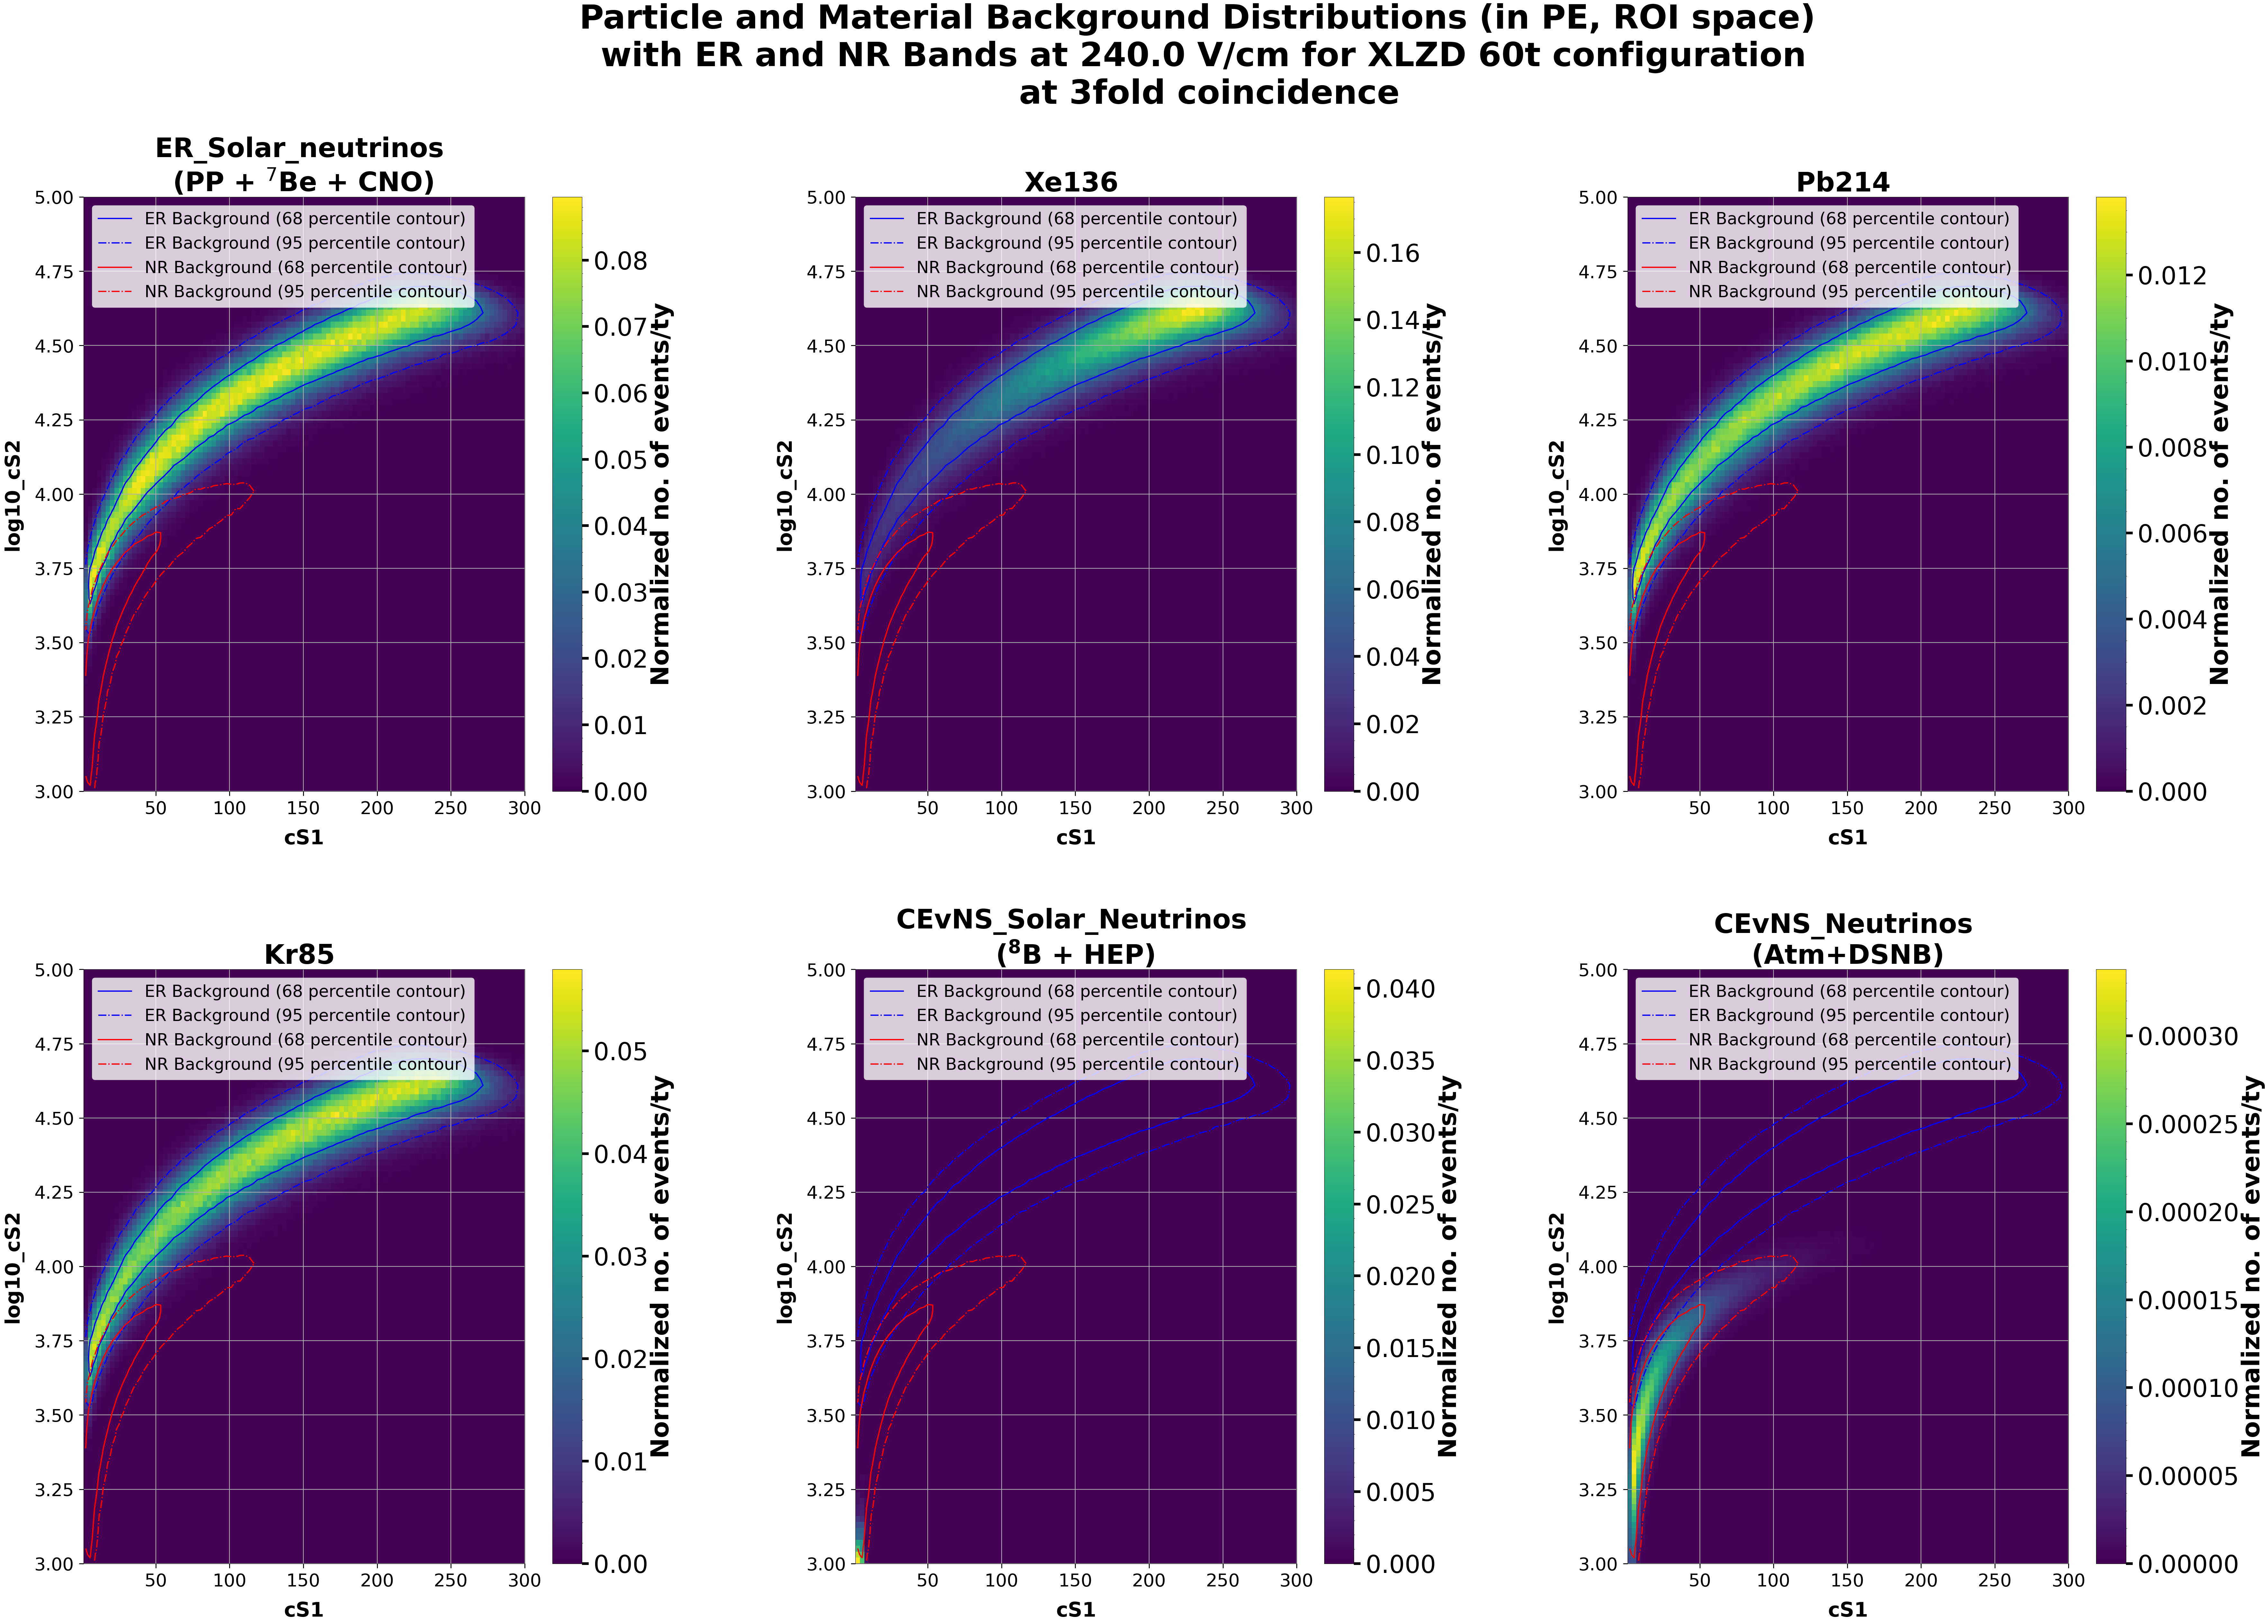

In [56]:
import numpy as np
import matplotlib.pyplot as plt

SolarER = fd.xlzd.XLZDvERSource(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)
Xe136 = fd.xlzd.XLZDXe136Source(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)
Pb214 = fd.xlzd.XLZDPb214Source(configuration=configuration,
                                drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                elife_ns=10000e3, g1=0.27)
Kr85 = fd.xlzd.XLZDKr85Source(configuration=configuration,
                               drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                               elife_ns=10000e3, g1=0.27)
CEvNS_solar = fd.xlzd.XLZDvNRSolarSource(configuration=configuration,
                                         drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                         elife_ns=10000e3, g1=0.27)
CEvNS_other = fd.xlzd.XLZDvNROtherSource(configuration=configuration,
                                         drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                         elife_ns=10000e3, g1=0.27)

# Define backgrounds in a dictionary with labels
backgrounds = {
    "ER_Solar_neutrinos \n(PP + $^7$Be + CNO)": {"hist": SolarER_hist, "source": SolarER },
    "Xe136": {"hist": Xe136_hist,"source": Xe136 },
    "Pb214": {"hist": Pb214_hist,"source": Pb214 },
    "Kr85": {"hist": Kr85_hist,"source": Kr85 },
    "CEvNS_Solar_Neutrinos \n($\mathbf{^8B}$ + HEP)": {"hist": CEvNS_solar_hist,"source": CEvNS_solar },
    "CEvNS_Neutrinos \n (Atm+DSNB)": {"hist": CEvNS_other_hist,"source": CEvNS_other }
}

# Determine grid size for subplots
num_bgs = len(backgrounds)
cols = 3  # You can adjust based on preference
rows = (num_bgs + cols - 1) // cols  

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(75, 25 * rows))
axes = axes.flatten()  
# Loop through backgrounds and plot
for idx, (bg_name, bg_info) in enumerate(backgrounds.items()):
    print(bg_name)
    ax = axes[idx]

    # Plot the background histogram
    plt.sca(ax)  # Set current axes
    ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.tick_params(axis='both', labelsize=40, width=2, length=10)
    im = bg_info["hist"].plot(alpha=1., colorbar=True, cblabel="Normalized no. of events/ty")
    plt.subplots_adjust(left=0.35, right=0.85, bottom=0.35, top=0.85)
    # Increase colorbar label font size
    cbar = im[0].colorbar  # Get the colorbar object
    cbar.ax.yaxis.label.set_size(55)  # Set font size
    cbar.ax.yaxis.label.set_weight("bold")  # Set bold font
    cbar.ax.tick_params(axis='both', labelsize=55, width=6, length=15)
    cbar.ax.yaxis.get_offset_text().set_size(45)  # Font size for the scale 
    cbar.ax.yaxis.get_offset_text().set_weight("bold") 
    cbar.ax.set_position([cbar.ax.get_position().x0 + 0.05,  # Shift right
                      cbar.ax.get_position().y0,  
                      cbar.ax.get_position().width, 
                      cbar.ax.get_position().height])
    

    # Plot ER and NR contours on top (these require ax)
    er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background" )
    nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")
    all_handles = er_handles + nr_handles
    # Title and grid
    ax.set_title(f"{bg_name} ", fontweight="bold", fontsize=60)
    plt.legend(handles=all_handles, loc="upper left", fontsize=37)
    ax.grid()

# Adjust layout
plt.style.use('seaborn-v0_8-poster')
fig.suptitle(f"Particle and Material Background Distributions (in PE, ROI space) \n with ER and NR Bands at {SolarER.drift_field} V/cm for XLZD {SolarER.configuration} configuration \n at {extracted_text} coincidence", 
             fontsize=75, fontweight="bold", y=1.01)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.4)
plt.show()

## Signal sources

WIMP

In [184]:
"""
masses = [9.0, 11.0, 16.0, 19.0, 32.0, 36.0, 40.0, 46.0,
          65.0, 91.0, 129.0, 182.0, 361.0, 508.0, 5000.0, 10000.0]
          """

'\nmasses = [9.0, 11.0, 16.0, 19.0, 32.0, 36.0, 40.0, 46.0,\n          65.0, 91.0, 129.0, 182.0, 361.0, 508.0, 5000.0, 10000.0]\n          '

In [29]:
"""
masses=[1.0,5.0,30.0]
for mass in masses:
    WIMP = fd.xlzd.XLZDWIMPSource(wimp_mass=mass, configuration=configuration,
                                 drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                 elife_ns=10000e3, g1=0.27)
    
    WIMP_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

    WIMP_data = WIMP.simulate(int(1e6))

    WIMP_hist.add(WIMP_data['cs1'], np.log10(WIMP_data['cs2']))

    WIMP_mu = WIMP.estimate_mu(n_trials=int(1e6))
    WIMP_hist.histogram = WIMP_hist.histogram / WIMP_hist.n * WIMP_mu

    plt.figure()
    WIMP_hist.plot()

    #pdfs[1][f'WIMP{mass:.0f}'] = WIMP_hist
"""


"\nmasses=[1.0,5.0,30.0]\nfor mass in masses:\n    WIMP = fd.xlzd.XLZDWIMPSource(wimp_mass=mass, configuration=configuration,\n                                 drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,\n                                 elife_ns=10000e3, g1=0.27)\n    \n    WIMP_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])\n\n    WIMP_data = WIMP.simulate(int(1e6))\n\n    WIMP_hist.add(WIMP_data['cs1'], np.log10(WIMP_data['cs2']))\n\n    WIMP_mu = WIMP.estimate_mu(n_trials=int(1e6))\n    WIMP_hist.histogram = WIMP_hist.histogram / WIMP_hist.n * WIMP_mu\n\n    plt.figure()\n    WIMP_hist.plot()\n\n    #pdfs[1][f'WIMP{mass:.0f}'] = WIMP_hist\n"

# MIGDAL Signal Templates (+ BG Model)

This plots the migdal signal for various masses with the background contours 

In [ ]:
# Define WIMP masses
masses = [0.5]
num_masses = len(masses)

# Define grid size
cols = 2  # Adjust based on preference
rows = (num_masses + cols - 1) // cols  # Compute required rows

# Create figure and grid
fig, axes = plt.subplots(rows, cols, figsize=(45, 25 * rows))
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate over WIMP masses and plot
for idx, mass in enumerate(masses):
    # Create Migdal source for given mass
    Migdal = fd.xlzd.XLZDMigdalSource(wimp_mass=mass, configuration=configuration,
                                      drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                      elife_ns=10000e3, g1=0.27, modulation=False)
    
    # Create histogram
    Migdal_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1 PE', 'log10_cS2 PE'])
    
    # Simulate Migdal events
    Migdal_data = Migdal.simulate(int(1e6))
    Migdal_hist.add(Migdal_data['cs1'], np.log10(Migdal_data['cs2']))
    
    # Normalize histogram
    Migdal_mu = Migdal.estimate_mu(n_trials=int(1e6))
    Migdal_hist.histogram = Migdal_hist.histogram / Migdal_hist.n * Migdal_mu
    
    # Store histogram in dictionary
    pdfs[1][f'WIMP0{int(mass * 10):02d}'] = Migdal_hist  # Stores histograms for each WIMP mass

    # Plot the histogram
    ax = axes[idx]
    plt.sca(ax)  # Set current axes
    ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.tick_params(axis='both', labelsize=40, width=2, length=10)
    im = Migdal_hist.plot(log_scale=False,alpha=1., colorbar=True, cblabel="Normalized no. of events/ty")
    plt.subplots_adjust(left=0.35, right=0.85, bottom=0.35, top=0.85)
    # Increase colorbar label font size
    cbar = im[0].colorbar  # Get the colorbar object
    cbar.ax.yaxis.label.set_size(55)  # Set font size
    cbar.ax.yaxis.label.set_weight("bold")  # Set bold font
    cbar.ax.xaxis.label.set_size(55)  # Set font size
    cbar.ax.xaxis.label.set_weight("bold")  # Set bold font
    cbar.ax.tick_params(axis='both', labelsize=55, width=6, length=15)
    cbar.ax.yaxis.get_offset_text().set_size(45)  # Font size for the scale 
    cbar.ax.yaxis.get_offset_text().set_weight("bold") 
    cbar.ax.set_position([cbar.ax.get_position().x0 + 0.05,  # Shift right
                      cbar.ax.get_position().y0,  
                      cbar.ax.get_position().width, 
                      cbar.ax.get_position().height])
    # Overlay ER and NR bands
    er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
    nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")
    
    # Title and labels
    ax.set_title(f"WIMP Mass: {mass:.2f} GeV", fontsize=60, fontweight="bold")
    ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    
    # Legend
    all_handles = er_handles + nr_handles
    plt.legend(handles=all_handles, loc="upper left", fontsize=37)
    ax.grid()
# Adjust layout and show the plot
plt.style.use('seaborn-v0_8-poster')
fig.suptitle(f"Migdal induced WIMP signal Distributions (in PE, ROI space) with ER and NR Bands  \n at {Migdal.drift_field} V/cm for XLZD {Migdal.configuration} configuration \n at {extracted_text} coincidence", fontsize=65, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.4)
plt.show()

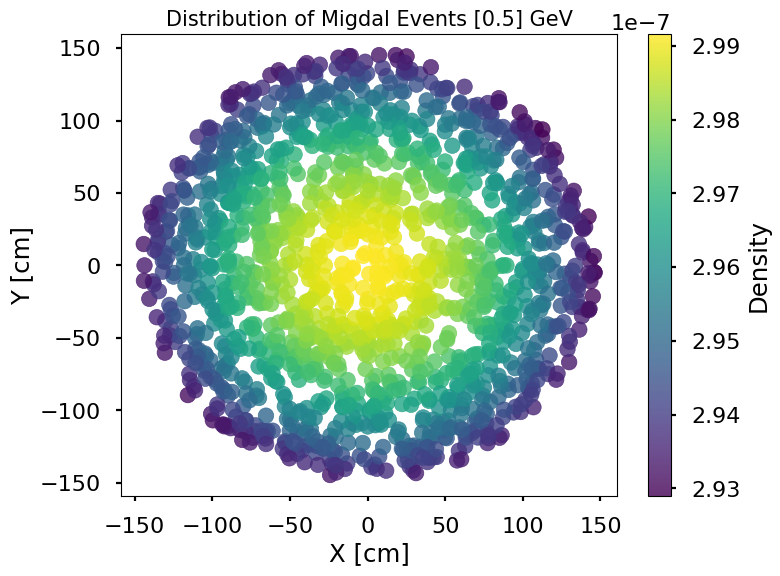

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# Extract x and y
x = Migdal_data['x']
y = Migdal_data['y']

# Compute the point density (z value)
xy = np.vstack([x, y])
kde = gaussian_kde(xy, bw_method=10.)  
z = kde(xy)  # Evaluate KDE at each (x, y) point

# Create the scatter plot with density-based colors
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-poster')  
scatter = plt.scatter(x, y, c=z, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Density')  # Add a color bar

# Add labels and title
plt.xlabel('X [cm]')  # Fixed typo here
plt.ylabel('Y [cm]')  # Fixed typo here
plt.title(f'Distribution of Migdal Events {masses} GeV', fontsize=15)

# Show the plot
plt.show()

# Spatial Maps for All BGS

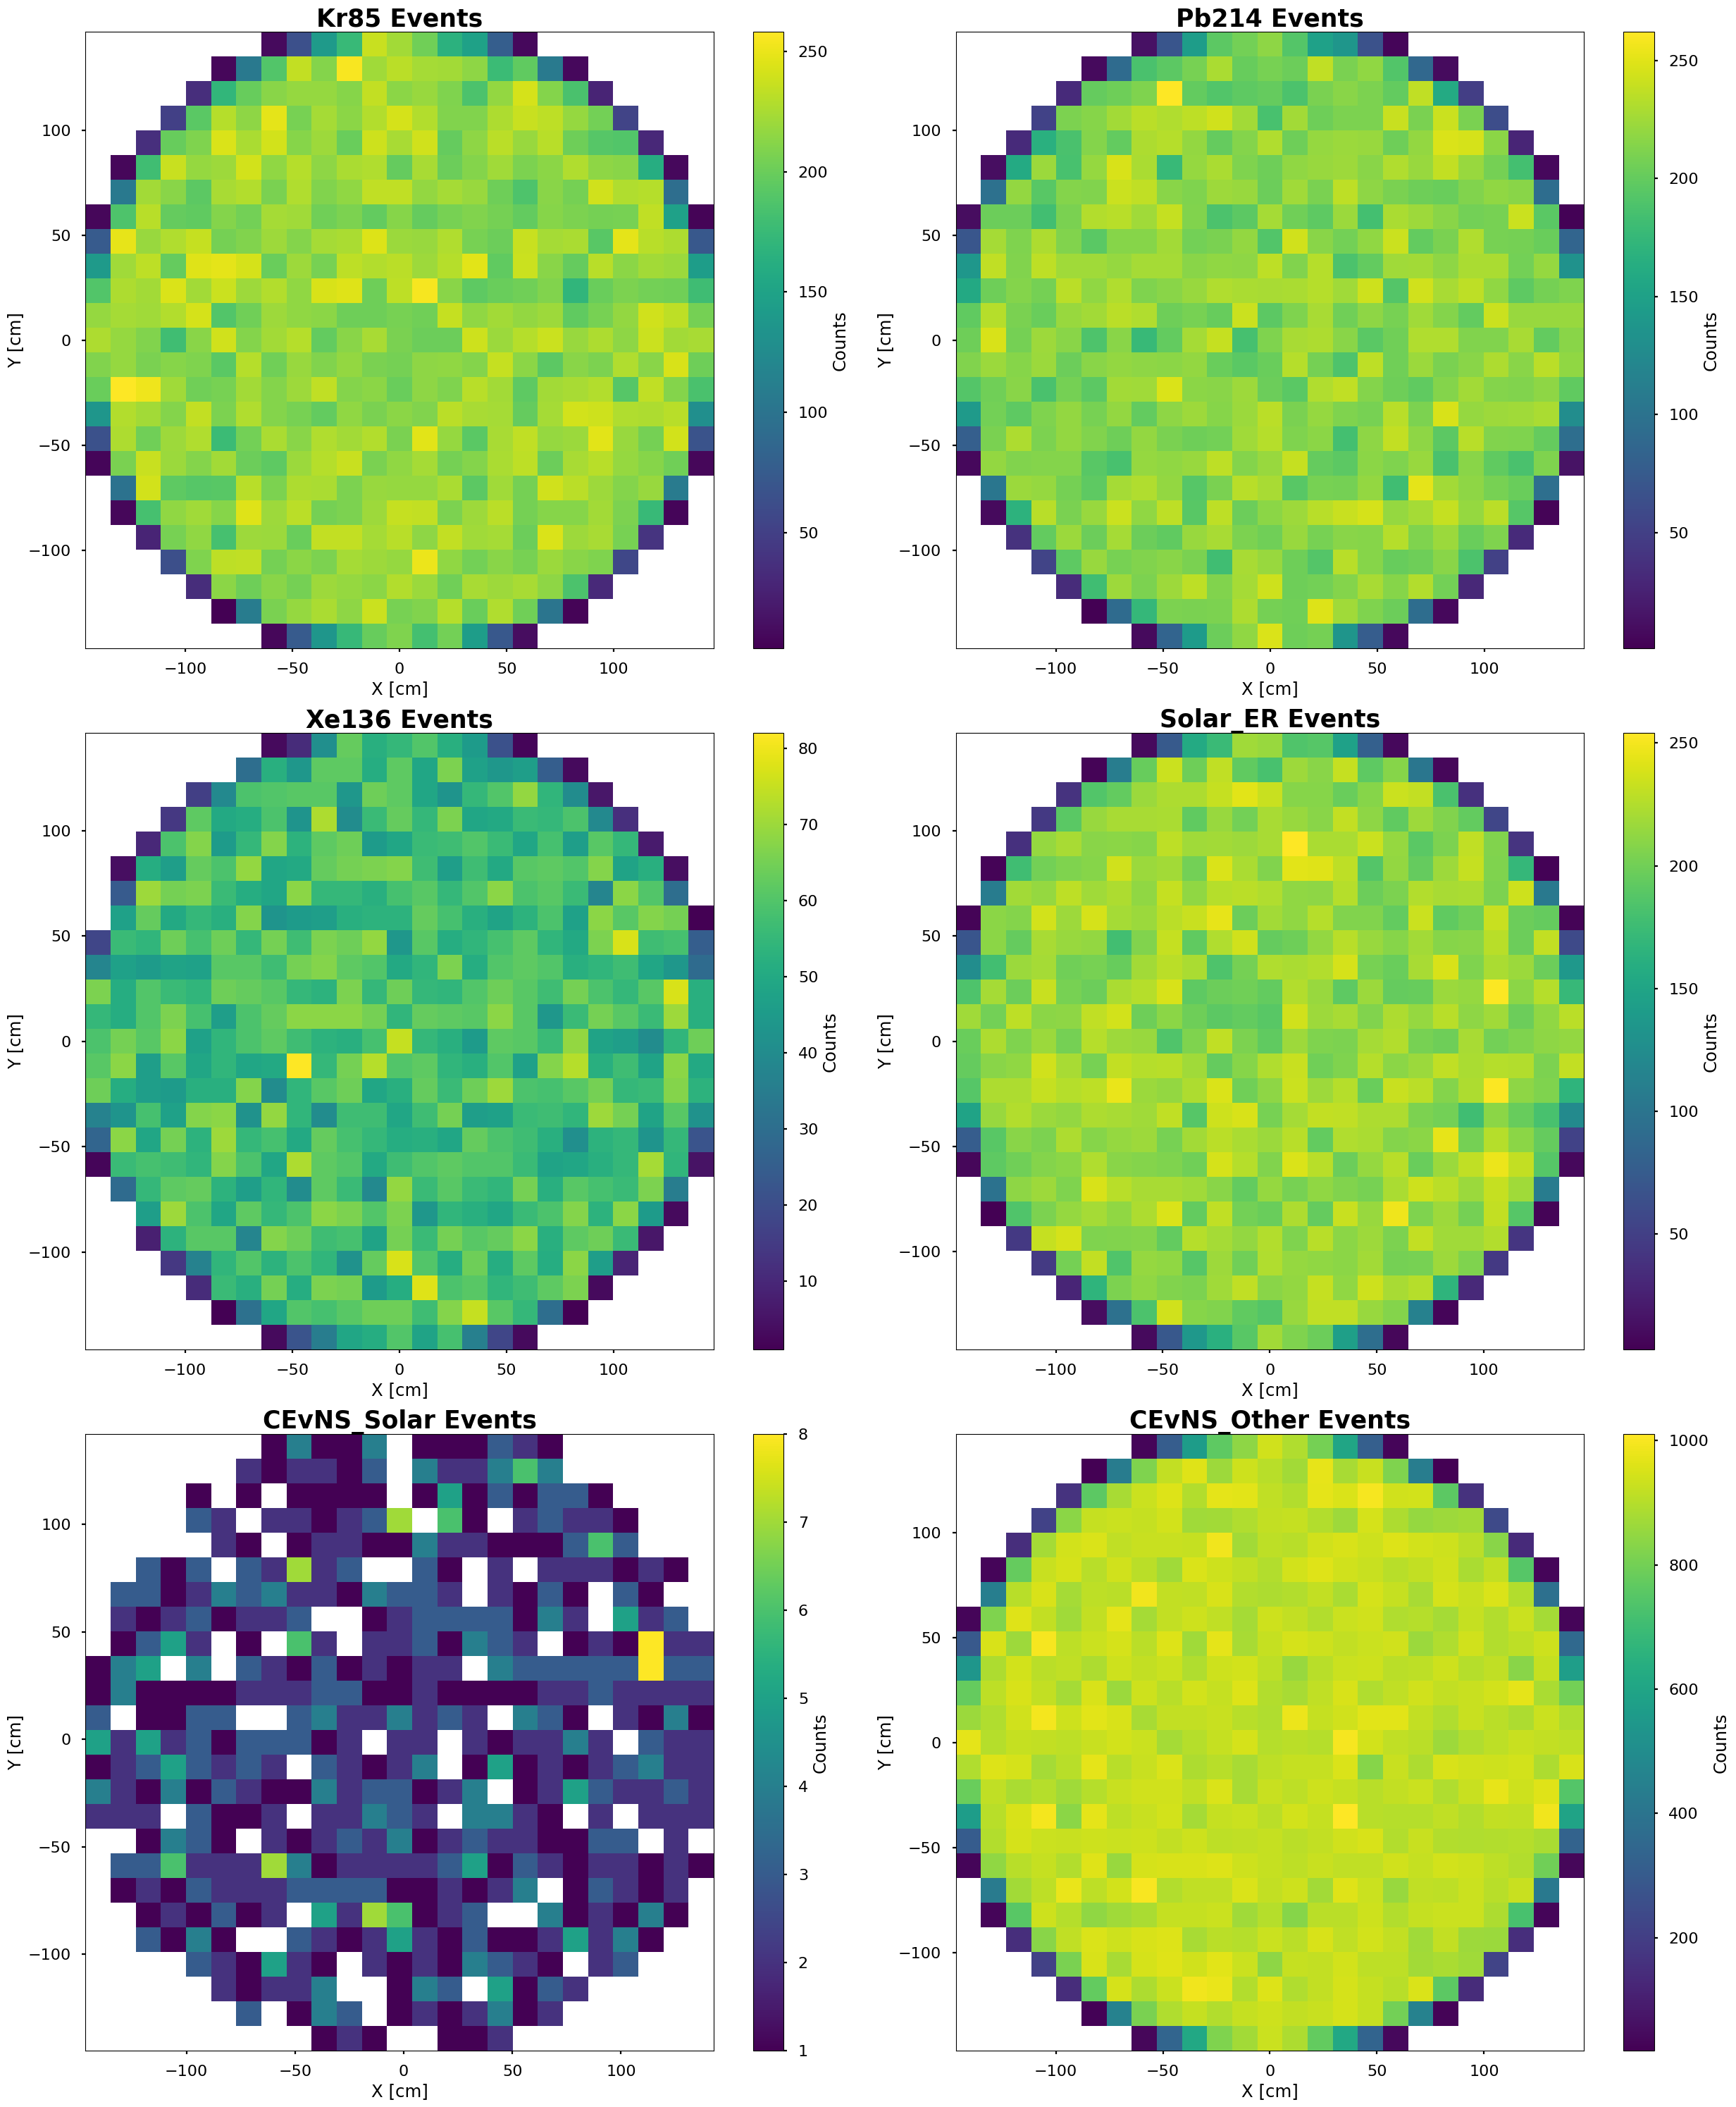

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store background data
background_data = {
    'Kr85': Kr85_data,
    'Pb214': Pb214_data,
    'Xe136': Xe136_data,
    'Solar_ER': SolarER_data,
    'CEvNS_Solar': CEvNS_solar_data,
    'CEvNS_Other': CEvNS_other_data
}

# Create grid layout for plots
plt.figure(figsize=(25, 30))
plt.style.use('seaborn-v0_8-poster')

# Loop through each background dataset
for i, (bg, data) in enumerate(background_data.items(), 1):
    plt.subplot(3, 2, i)

    # Extract x and y
    x = data['x']
    y = data['y']

    # 2D Histogram
    hist = plt.hist2d(x, y, bins=25, cmap='viridis', cmin=1)

    # Colorbar
    plt.colorbar(hist[3], label='Counts')

    # Add labels and title
    plt.xlabel('X [cm]')
    plt.ylabel('Y [cm]')
    plt.title(f'{bg} Events', fontsize=25,fontweight="bold")

# Adjust spacing to prevent overlap
plt.tight_layout()
plt.show()


## Save all PDFs

In [ ]:
if not os.path.exists('PDFs'):
    os.makedirs('PDFs')
pkl.dump(pdfs, open(f'PDFs/pdfs_mig_SI_{Migdal.configuration}_0.3-2.0Gev_{extracted_text}.pkl', 'wb'))

# Typical WIMP Signal v/s MIgdal WIMP Signal

In [ ]:
pdfs_1= [dict(), dict()]

masses_migdal = [1.0,2.0,5.0,30.0]  # Masses for Migdal WIMP
masses_wimp = [1.0,2.0,5.0,30.0]  # Masses for Typical WIMP
num_masses = max(len(masses_migdal), len(masses_wimp))  # Maximum rows needed

# Define grid size
cols = 2  # One column for Migdal, one for Typical WIMP
rows = num_masses  # One row per (Migdal, WIMP) pair

# Create figure and grid
fig, axes = plt.subplots(rows, cols, figsize=(45, 25 * rows))
axes = np.array(axes).reshape(rows, cols)  # Ensure correct shape



# Iterate over the maximum number of rows
for idx in range(num_masses):
    
    if idx < len(masses_migdal):
        mass_migdal = masses_migdal[idx]
        Migdal = fd.xlzd.XLZDMigdalSource(wimp_mass=mass_migdal, configuration=configuration,
                                          drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                          elife_ns=10000e3, g1=0.27, modulation=False)

        Migdal_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])
        Migdal_data = Migdal.simulate(int(1e6))
        Migdal_hist.add(Migdal_data['cs1'], np.log10(Migdal_data['cs2']))

        Migdal_mu = Migdal.estimate_mu(n_trials=int(1e6))
        Migdal_hist.histogram = Migdal_hist.histogram / Migdal_hist.n * Migdal_mu
        print(f"{Migdal_hist} counts/ty", Migdal_hist.n)
        pdfs_1[0][f'WIMP0{int(mass_migdal * 10):02d}'] = Migdal_hist  # Stores histograms for each WIMP mass

        # Plot Migdal histogram
        ax = axes[idx, 0]  # Left column
        plt.sca(ax)
        ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
        ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
        ax.tick_params(axis='both', labelsize=40, width=2, length=10)

        im = Migdal_hist.plot(log_scale=False, alpha=1., colorbar=True, cblabel="Normalized no. of events/ty")

        # Increase colorbar label font size
        cbar = im[0].colorbar
        cbar.ax.yaxis.label.set_size(55)
        cbar.ax.yaxis.label.set_weight("bold")
        cbar.ax.tick_params(axis='both', labelsize=55, width=6, length=15)

        # Overlay ER and NR bands
        er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
        nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")

        ax.set_title(f"Migdal WIMP: {mass_migdal:.2f} GeV", fontsize=60, fontweight="bold")
        plt.legend(handles=er_handles + nr_handles, loc="upper left", fontsize=37)
        ax.grid()

    
    if idx < len(masses_wimp):
        mass_wimp = masses_wimp[idx]
        Typical_WIMP = fd.xlzd.XLZDWIMPSource(wimp_mass=mass_wimp, configuration=configuration,
                                 drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                 elife_ns=10000e3, g1=0.27)

        WIMP_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])
        WIMP_data = Typical_WIMP.simulate(int(1e6))
        WIMP_hist.add(WIMP_data['cs1'], np.log10(WIMP_data['cs2']))

        WIMP_mu = Typical_WIMP.estimate_mu(n_trials=int(1e6))
        WIMP_hist.histogram = WIMP_hist.histogram / WIMP_hist.n * WIMP_mu
        pdfs_1[1][f'WIMP0{int(mass_wimp * 10):02d}'] = WIMP_hist  # Stores histograms for each WIMP mass
        

        # Plot Typical WIMP histogram
        ax = axes[idx, 1]  # Right column
        plt.sca(ax)
        ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
        ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
        ax.tick_params(axis='both', labelsize=40, width=2, length=10)

        im = WIMP_hist.plot(log_scale=False, alpha=1., colorbar=True, cblabel="Normalized no. of events/ty")

        # Increase colorbar label font size
        cbar = im[0].colorbar
        cbar.ax.yaxis.label.set_size(55)
        cbar.ax.yaxis.label.set_weight("bold")
        cbar.ax.xaxis.label.set_size(55)  # Set font size
        cbar.ax.xaxis.label.set_weight("bold")  # Set bold font
        cbar.ax.tick_params(axis='both', labelsize=55, width=6, length=15)

        # Overlay ER and NR bands
        er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
        nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")

        ax.set_title(f"Typical WIMP: {mass_wimp:.2f} GeV", fontsize=60, fontweight="bold")
        plt.legend(handles=er_handles + nr_handles, loc="upper left", fontsize=37)
        ax.grid()

# Adjust layout and show the plot
plt.style.use('seaborn-v0_8-poster')
fig.suptitle(f"Migdal vs. Typical WIMP Signal Distributions \nwith ER/NR Bands for XLZD {Migdal.configuration} T at {Migdal.drift_field} V/cm",
             fontsize=65, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.4)
plt.show()


# Checking rates from typical WIMPS and Migdal Induced WIMPS 

In [ ]:
print(pdfs_1[1].items())
for key, hist in pdfs_1[0].items():
    print(f"Running hist.n on migdal induced {key}:")
    print(hist.n) 
for key, hist in pdfs_1[1].items():
    print(f"Running hist.n on typical {key}:")
    print(hist.n) 

# Making WIMP Templates with Annual Modulation ON 

Gotta test how modulation affects sensitivity ....for an year averaged study, like this one, the annual modulation won't matter as the averaging effect would simply cancel out any modulation effects...however, if a future study wants to conduct this study in a specific time window of an year, then wimprates can easily accomodate that with some key word arguments in Migdal source function below.

We found no difference (as expected) from a year averaged migdal template with modulation ON, therefore, in the above cases we turned it OFF as the template generation process is much faster (from 18 mins/ mass to 30secs/mass)

In [ ]:
# Define WIMP masses
masses = [1.0]
num_masses = len(masses)

# Define grid size
cols = 2  # Adjust based on preference
rows = (num_masses + cols - 1) // cols  # Compute required rows

# Create figure and grid
fig, axes = plt.subplots(rows, cols, figsize=(45, 25 * rows))
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate over WIMP masses and plot
for idx, mass in enumerate(masses):
    # Create Migdal source for given mass
    Migdal = fd.xlzd.XLZDMigdalSource(wimp_mass=mass, configuration=configuration,
                                      drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                      elife_ns=10000e3, g1=0.27, modulation=True)
    
    # Create histogram
    Migdal_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])
    
    # Simulate Migdal events
    Migdal_data = Migdal.simulate(int(1e6))
    Migdal_hist.add(Migdal_data['cs1'], np.log10(Migdal_data['cs2']))
    
    # Normalize histogram
    Migdal_mu = Migdal.estimate_mu(n_trials=int(1e6))
    Migdal_hist.histogram = Migdal_hist.histogram / Migdal_hist.n * Migdal_mu
    
    # Store histogram in dictionary
    pdfs[1][f'WIMP0{int(mass * 10):02d}'] = Migdal_hist  # Stores histograms for each WIMP mass

    # Plot the histogram
    ax = axes[idx]
    plt.sca(ax)  # Set current axes
    ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.tick_params(axis='both', labelsize=40, width=2, length=10)
    im = Migdal_hist.plot(log_scale=False,alpha=1., colorbar=True, cblabel="Normalized no. of events/ty")
    plt.subplots_adjust(left=0.35, right=0.85, bottom=0.35, top=0.85)
    # Increase colorbar label font size
    cbar = im[0].colorbar  # Get the colorbar object
    cbar.ax.yaxis.label.set_size(55)  # Set font size
    cbar.ax.yaxis.label.set_weight("bold")  # Set bold font
    cbar.ax.xaxis.label.set_size(55)  # Set font size
    cbar.ax.xaxis.label.set_weight("bold")  # Set bold font
    cbar.ax.tick_params(axis='both', labelsize=55, width=6, length=15)
    cbar.ax.yaxis.get_offset_text().set_size(45)  # Font size for the scale 
    cbar.ax.yaxis.get_offset_text().set_weight("bold") 
    cbar.ax.set_position([cbar.ax.get_position().x0 + 0.05,  # Shift right
                      cbar.ax.get_position().y0,  
                      cbar.ax.get_position().width, 
                      cbar.ax.get_position().height])
    # Overlay ER and NR bands
    er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
    nr_handles = plot_hist_all(NR_hist, color="red", label="NR Background")
    
    # Title and labels
    ax.set_title(f"WIMP Mass: {mass:.2f} GeV", fontsize=60, fontweight="bold")
    ax.set_xlabel("cS1 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    ax.set_ylabel("log10_cS2 (PE)", fontsize=45, fontweight="bold", labelpad=25)
    
    # Legend
    all_handles = er_handles + nr_handles
    plt.legend(handles=all_handles, loc="upper left", fontsize=37)
    ax.grid()
# Adjust layout and show the plot
plt.style.use('seaborn-v0_8-poster')
fig.suptitle(f"Migdal induced WIMP signal Distributions (in PE, ROI space) with ER and NR Bands  \n at {Migdal.drift_field} V/cm for XLZD {Migdal.configuration} configuration \n at {extracted_text} coincidence", fontsize=65, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.4)
plt.show()


# Checking WIMP rates for 1 Gev with annual modulation

In [ ]:
for key, hist in pdfs[1].items():
    print(f"Running hist.n on {key}:")
    print(hist.n)

 # Script for density counts v/s energy B+S

In [ ]:

masses = [1.0]
for mass in masses: 
# Create a Migdal source for the given mass
    Migdal = fd.xlzd.XLZDMigdalSource(wimp_mass=mass, configuration=configuration,
                                      drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                      elife_ns=10000e3, g1=0.27,modulation=False )# if modulation = True, takes 18 mins per mass !,30 secs faster second time around
    
    # Create a 2D histogram for cS1 and log10(cS2)
    Migdal_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2']) # Decreased Detector threshold in XLZD.ini
    
    # Simulate Migdal data (1 million events)
    Migdal_data_6= Migdal.simulate(int(1e6)) 


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')
plt.hist(
    Migdal_data_6.ces_er_equivalent,
    bins=50,
    color='green',
    alpha=0.9,
    label="Migdal Data 1 GeV/c²",
    weights=np.ones_like(Migdal_data_6.ces_er_equivalent) / 1e6
)

plt.hist(
    SolarER_data.ces_er_equivalent,
    bins=50,
    color='red',
    alpha=0.5,
    label="ER Solar Neutrinos",
    weights=np.ones_like(SolarER_data.ces_er_equivalent) / 1e6
)


plt.xlabel("Energy (KeV)",fontweight="bold",fontsize=26)
plt.ylabel(" Normalised Counts Density",fontweight="bold",fontsize=20)
plt.title("Signal v/s ER_Solar Background",fontweight="bold",fontsize=26)
plt.legend()
plt.grid()
plt.show()

# Counts/ty

In [31]:
print("SolarER Histogram Count:", SolarER_hist.n)
print("Pb214 Histogram Count:", Pb214_hist.n)
print("Kr85 Histogram Count:", Kr85_hist.n)
print("CEvNS_other Histogram Count:", CEvNS_other_hist.n)
print("Xe136 Histogram Count:", Xe136_hist.n)
#print("AC Histogram Count:", AC_temp.n)
print("CEvNS_Solar", CEvNS_solar_hist.n)
#print("Migdal", Migdal_hist.n)


SolarER Histogram Count: 75.5578211415863
Pb214 Histogram Count: 11.052846803655626
Kr85 Histogram Count: 45.4966265256958
CEvNS_other Histogram Count: 0.04910480345477165
Xe136 Histogram Count: 85.83562140710448
CEvNS_Solar 0.3298559566345215


# Background Model Plot
Creating a plot to graphically represent all our material and particle bgs such that on the y-axis we have counts that have been normalised first with respect to total counts(events actually detected by detetctor) coming from MC and then scaled up with prior counts from theory (different for different sources) 

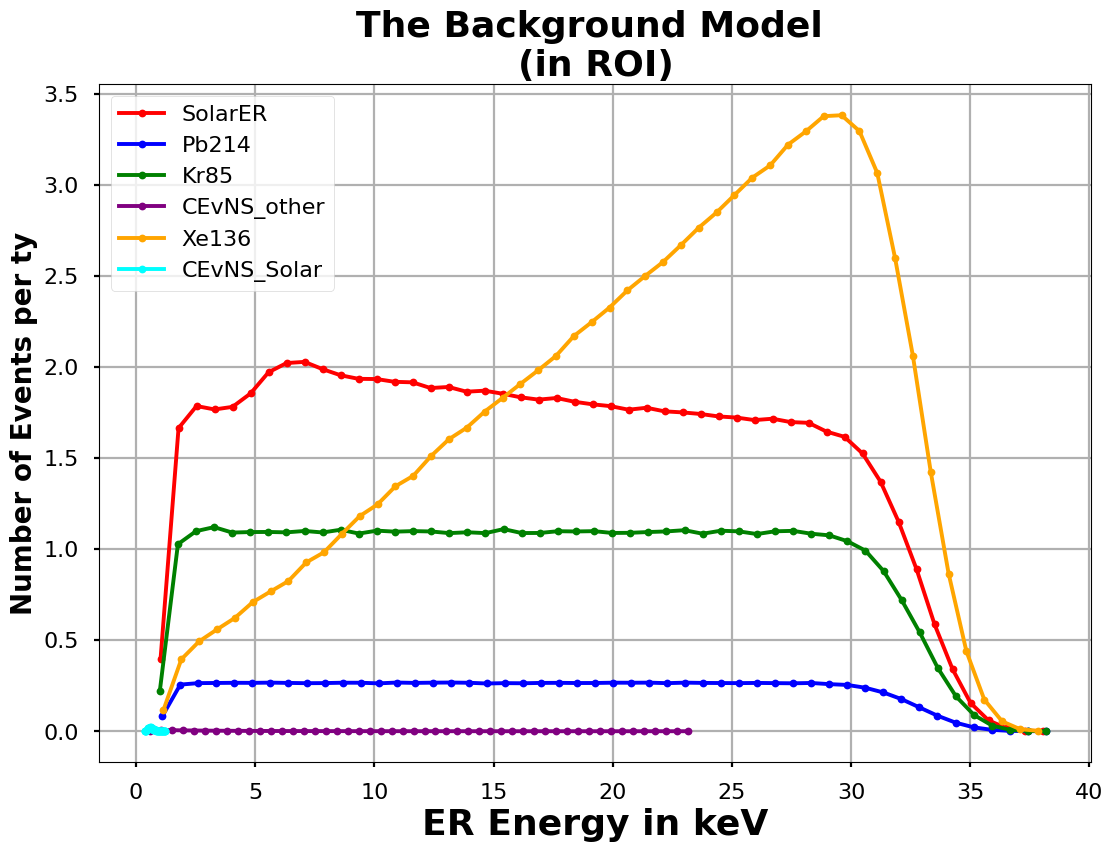

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

# Dictionary mapping background sources to histograms and expected counts
backgrounds = {
    "SolarER": (SolarER_data.ces_er_equivalent,SolarER_hist.n),
    "Pb214": (Pb214_data.ces_er_equivalent, Pb214_hist.n),
    "Kr85": (Kr85_data.ces_er_equivalent,Kr85_hist.n),
    "CEvNS_other": (CEvNS_other_data.ces_er_equivalent, CEvNS_other_hist.n),
    "Xe136": (Xe136_data.ces_er_equivalent, Xe136_hist.n),
    #"AC": (AC_temp, 600),
    "CEvNS_Solar": (CEvNS_solar_data.ces_er_equivalent, CEvNS_solar_hist.n),
    #"WIMP_0.6_GeV_Migdal": (Migdal_data.ces_er_equivalent, Migdal_hist.n),
    
}

# Define colors for different backgrounds (optional)
colors = ["red", "blue","green", "purple", "orange", "cyan", "magenta"]


num_bins = 50
# Loop through each background source
for i, (bg_name, (energy_values, expected_counts_per_ty)) in enumerate(backgrounds.items()):
    counts, bin_edges = np.histogram(energy_values, bins=num_bins)
    #print(np.sum(counts)) 

    # Normalize by total counts
    counts = counts / np.sum(counts)

    # Scale by expected counts per ty
    counts = counts * expected_counts_per_ty

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot
    plt.plot(bin_centers, counts, marker='.', linestyle='-', color=colors[i % len(colors)], label=bg_name)

# Labels and title
plt.xlabel("ER Energy in keV",fontweight="bold",fontsize=26)
plt.ylabel("Number of Events per ty",fontweight="bold",fontsize=20)

#plt.yscale('log')
plt.title("The Background Model \n(in ROI)",fontweight="bold",fontsize=26)
plt.legend()
plt.grid()

# Show plot
plt.show()



# Signal Temp with Gaussian Fits on Projections

We also tested (line 49 there's an xlim...comment it out if you wanna see the whole plot w/o cuts) the signal visuals near the threshold across 3-fold and 4-fold, the signal looks pretty much the same except at the very threshold where as expected  for the 4-fold cases, some events were lost, but otherwise the same 

/Users/amirr/Desktop/Flame/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(
/Users/amirr/Desktop/Flame/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(
/Users/amirr/Desktop/Flame/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(
/Users/amirr/Desktop/Flame/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(
/Users/amirr/Desktop/Flame/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are c

------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------
------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------
------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------
------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------
------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------
------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C.

/Users/amirr/Desktop/Flame/flamedisx/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


Total events for WIMP mass 1.0 GeV: 40418.0
Estimated mu for WIMP mass 1.0 GeV: 4.868593547766027e-06


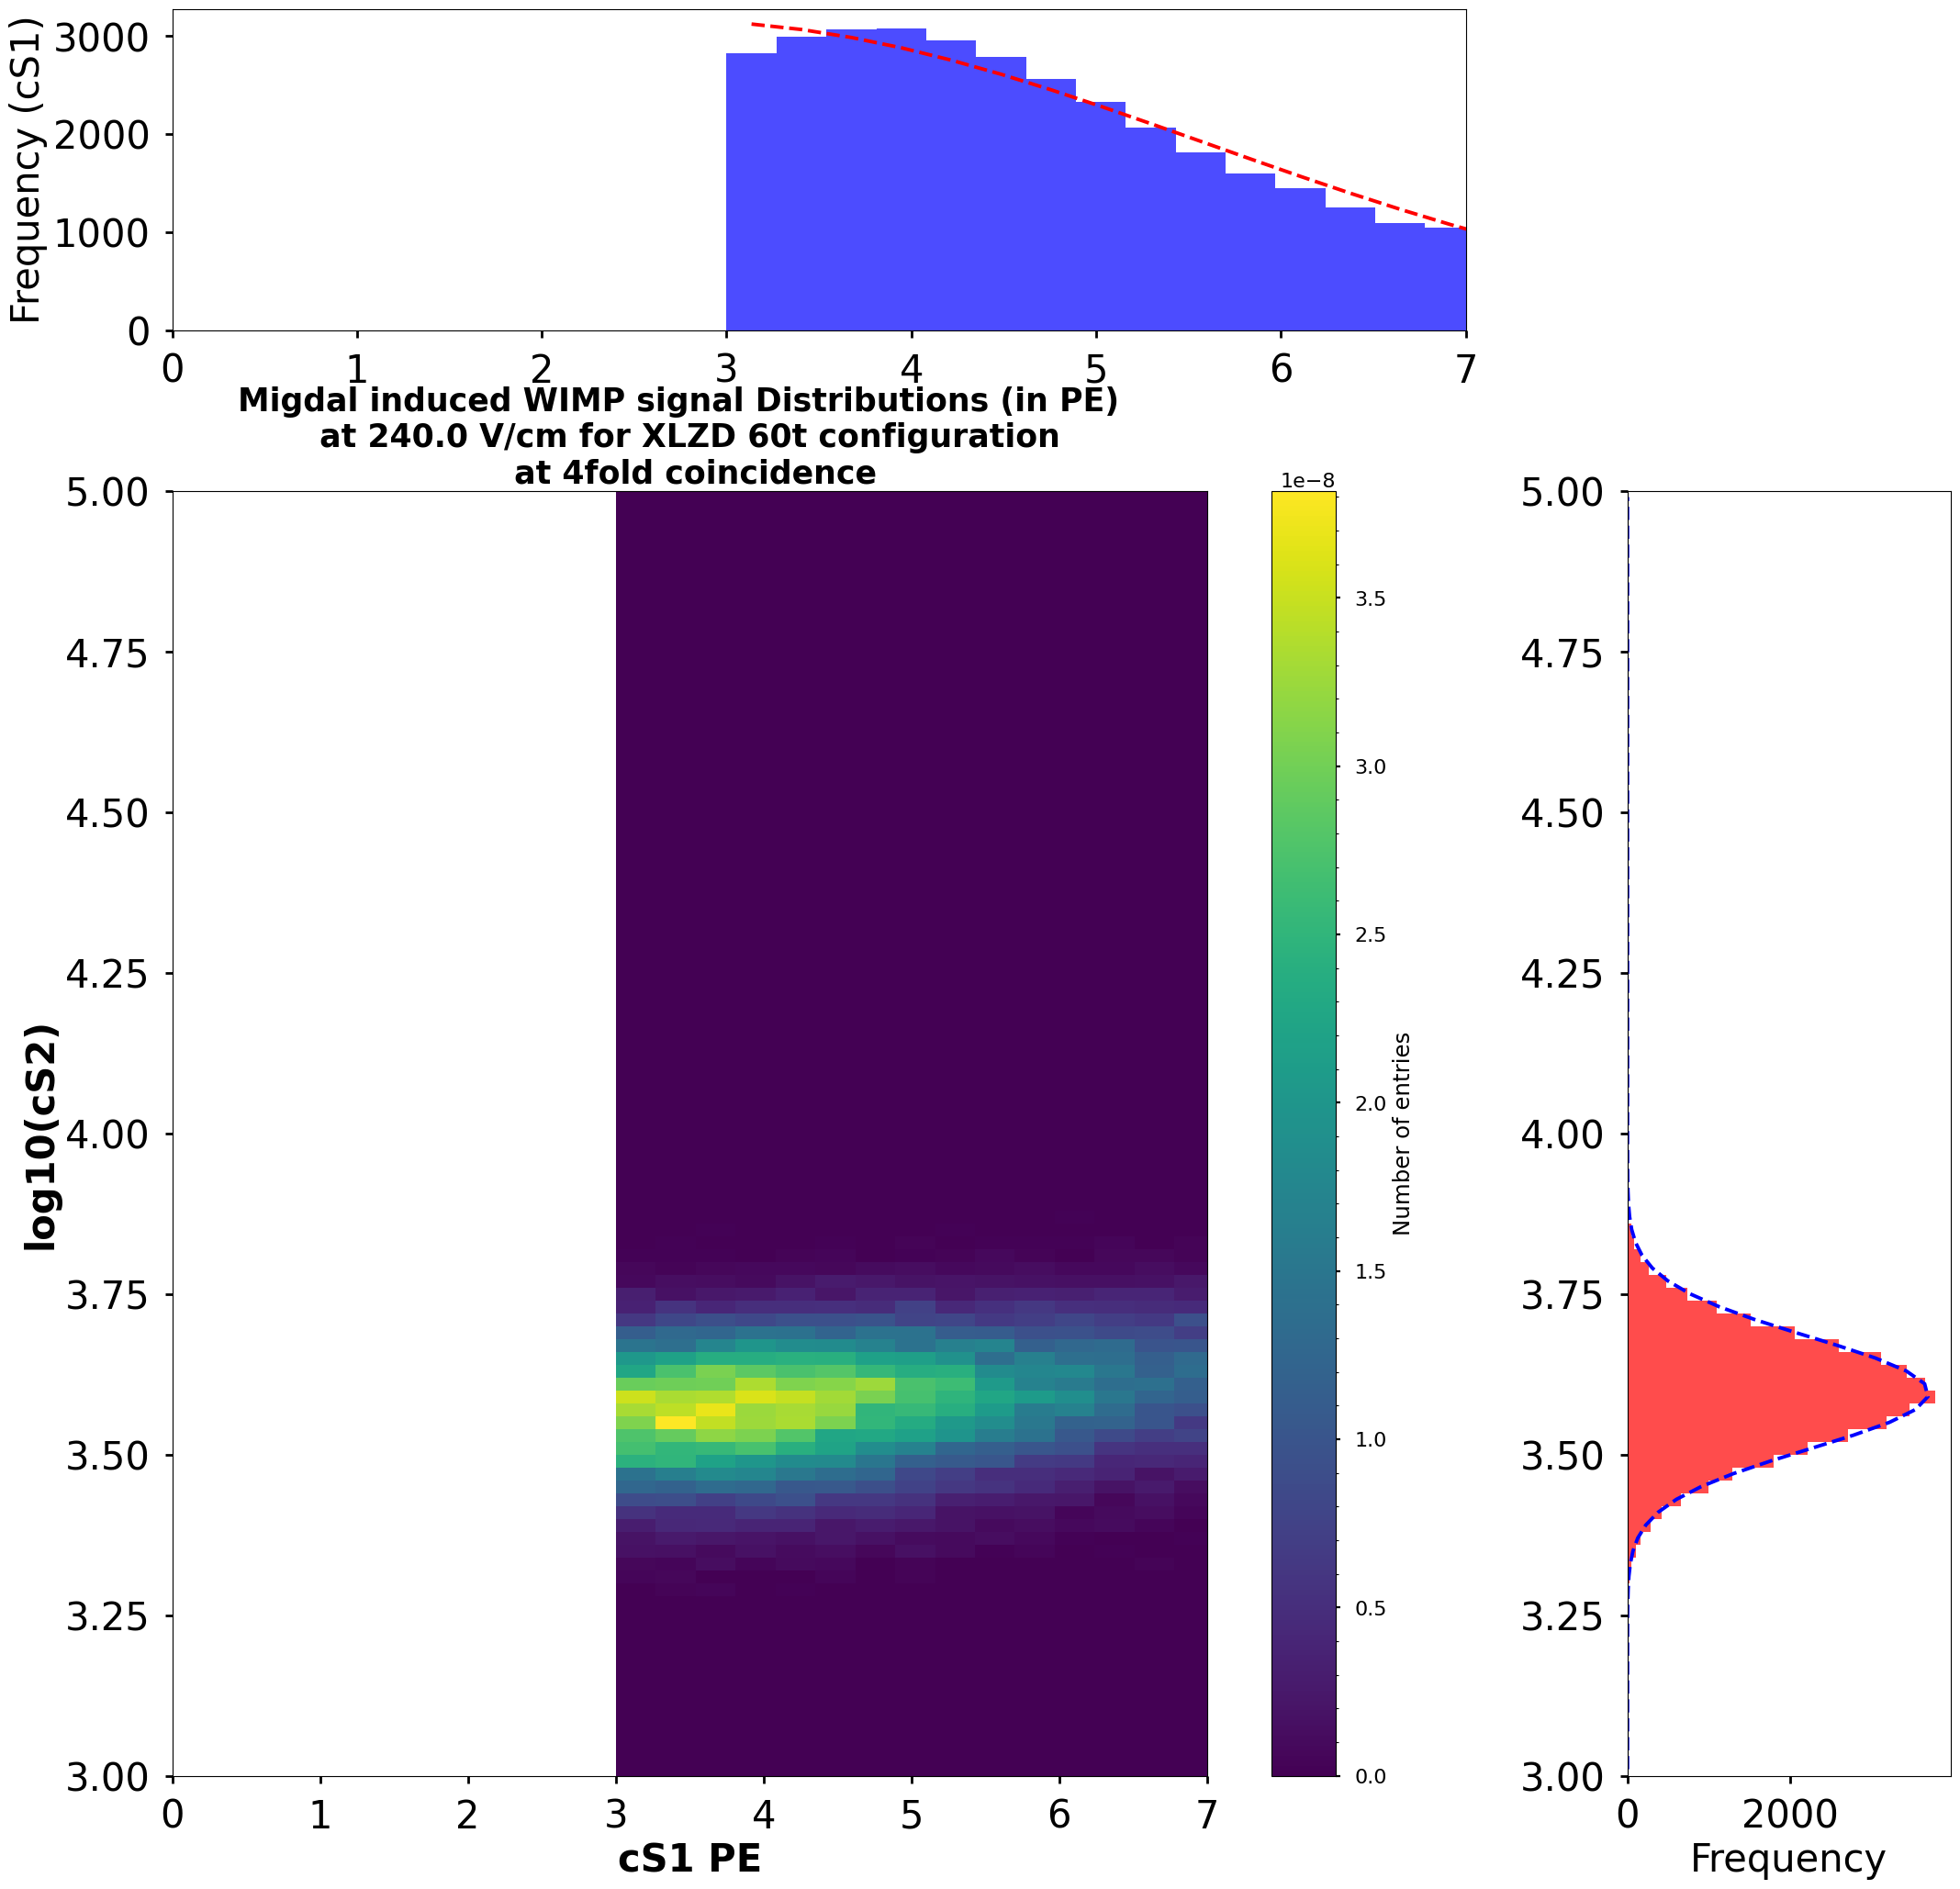


Gaussian Fit Results for WIMP mass 1.0 GeV:
  - cS1 Projection: Mean = 2.73, Sigma = 2.86
  - log10(cS2) Projection: Mean = 3.60, Sigma = 0.09



In [27]:
masses = [1.0]
for mass in masses: 
    # Create a Migdal source for the given mass
    Migdal = fd.xlzd.XLZDMigdalSource(wimp_mass=mass, configuration=configuration,
                                      drift_field_V_cm=drift_field, gas_field_kV_cm=7.5,
                                      elife_ns=10000e3, g1=0.27, modulation=False)
    
    # Create a 2D histogram
    Migdal_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1 PE', 'log10_cS2 PE'])
    
    # Simulate Migdal data (How ?)
    Migdal_data = Migdal.simulate(int(1e6))
    
    # Add simulated data to the histogram
    Migdal_hist.add(Migdal_data['cs1'], np.log10(Migdal_data['cs2']))
    
    print(f"Total events for WIMP mass {mass} GeV: {Migdal_hist.n}")
    
    # Estimate mean number of events (mu) from the simulation
    Migdal_mu = Migdal.estimate_mu(n_trials=int(1e6))
    print(f"Estimated mu for WIMP mass {mass} GeV: {Migdal_mu}")
    
    # Normalize histogram and scale with theoretical prior (why?)
    Migdal_hist.histogram = Migdal_hist.histogram / Migdal_hist.n * Migdal_mu

    # Compute 1D projections
    bin_centers_cS1 = (Migdal_hist.bin_edges[0][:-1] + Migdal_hist.bin_edges[0][1:]) / 2
    bin_centers_cS2 = (Migdal_hist.bin_edges[1][:-1] + Migdal_hist.bin_edges[1][1:]) / 2

    counts_cS1, _ = np.histogram(Migdal_data['cs1'], bins=Migdal_hist.bin_edges[0])
    counts_cS2, _ = np.histogram(np.log10(Migdal_data['cs2']), bins=Migdal_hist.bin_edges[1])

    # Fit Gaussian to cS1 projection
    popt_cS1, _ = opt.curve_fit(gaussian, bin_centers_cS1, counts_cS1, p0=[np.max(counts_cS1), np.mean(Migdal_data['cs1']), np.std(Migdal_data['cs1'])])
    A_cS1, mu_cS1, sigma_cS1 = popt_cS1

    # Fit Gaussian to log10(cS2) projection
    popt_cS2, _ = opt.curve_fit(gaussian, bin_centers_cS2, counts_cS2, p0=[np.max(counts_cS2), np.mean(np.log10(Migdal_data['cs2'])), np.std(np.log10(Migdal_data['cs2']))])
    A_cS2, mu_cS2, sigma_cS2 = popt_cS2

    # Plot histograms with Gaussian fits
    fig = plt.figure(figsize=(25, 25))
    gs = gridspec.GridSpec(4, 4, hspace=0.5, wspace=0.5)

    # Main 2D histogram plot
    ax_main = fig.add_subplot(gs[1:4, 0:3])
   
    ax_main.set_title(f"Migdal induced WIMP signal Distributions (in PE)  \n at {Migdal.drift_field} V/cm for XLZD {Migdal.configuration} configuration \n at {extracted_text} coincidence", fontsize=25, fontweight="bold")
    
    Migdal_hist.plot(log_scale=False)
    ax_main.set_xlim(0,7)
    ax_main.set_xlabel('cS1 PE', fontsize=30, fontweight="bold")
    ax_main.set_ylabel('log10(cS2)', fontsize=30, fontweight="bold")

    # Correct way to format tick labels
    ax_main.tick_params(axis='both', labelsize=30, width=2, length=6)

    


    # Projection for cS1 (x-axis) on top
    ax_xproj = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_xproj.hist(Migdal_data['cs1'], bins=Migdal_hist.bin_edges[0], color='blue', alpha=0.7)
    ax_xproj.plot(bin_centers_cS1, gaussian(bin_centers_cS1, *popt_cS1), 'r--', label=f'Gaussian Fit\n$\\mu$={mu_cS1:.2f}, $\\sigma$={sigma_cS1:.2f}')
    #ax_xproj.legend()
    ax_xproj.tick_params(axis='both', labelsize=30, width=2, length=6)
    ax_xproj.set_ylabel('Frequency (cS1)',fontsize=30)

    # Projection for log10(cS2) (y-axis) on the right
    ax_yproj = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
    ax_yproj.hist(np.log10(Migdal_data['cs2']), bins=Migdal_hist.bin_edges[1], orientation='horizontal', color='red', alpha=0.7, label='Histogram')
    ax_yproj.plot(gaussian(bin_centers_cS2, *popt_cS2), bin_centers_cS2, 'b--', label=f'Gaussian Fit\n$\\mu$={mu_cS2:.2f}, $\\sigma$={sigma_cS2:.2f}')
    #ax_yproj.legend()
    ax_yproj.tick_params(axis='both', labelsize=30, width=2, length=6)
    ax_yproj.set_xlabel('Frequency',fontsize=30)

    plt.show()
    #plt.style.use('seaborn-v0_8-poster')

    # Print Gaussian fit parameters
    print(f"\nGaussian Fit Results for WIMP mass {mass} GeV:")
    print(f"  - cS1 Projection: Mean = {mu_cS1:.2f}, Sigma = {sigma_cS1:.2f}")
    print(f"  - log10(cS2) Projection: Mean = {mu_cS2:.2f}, Sigma = {sigma_cS2:.2f}\n")

    # Store the histogram in the pdfs dictionary
   # pdfs[1][f'WIMP0{int(mass * 10):02d}'] = Migdal_hist

# Superposing AC events and 1Gev WIMP signal 

Can be done with any WIMP mass, just change the WIMP mass definition above 

11035.925739191636


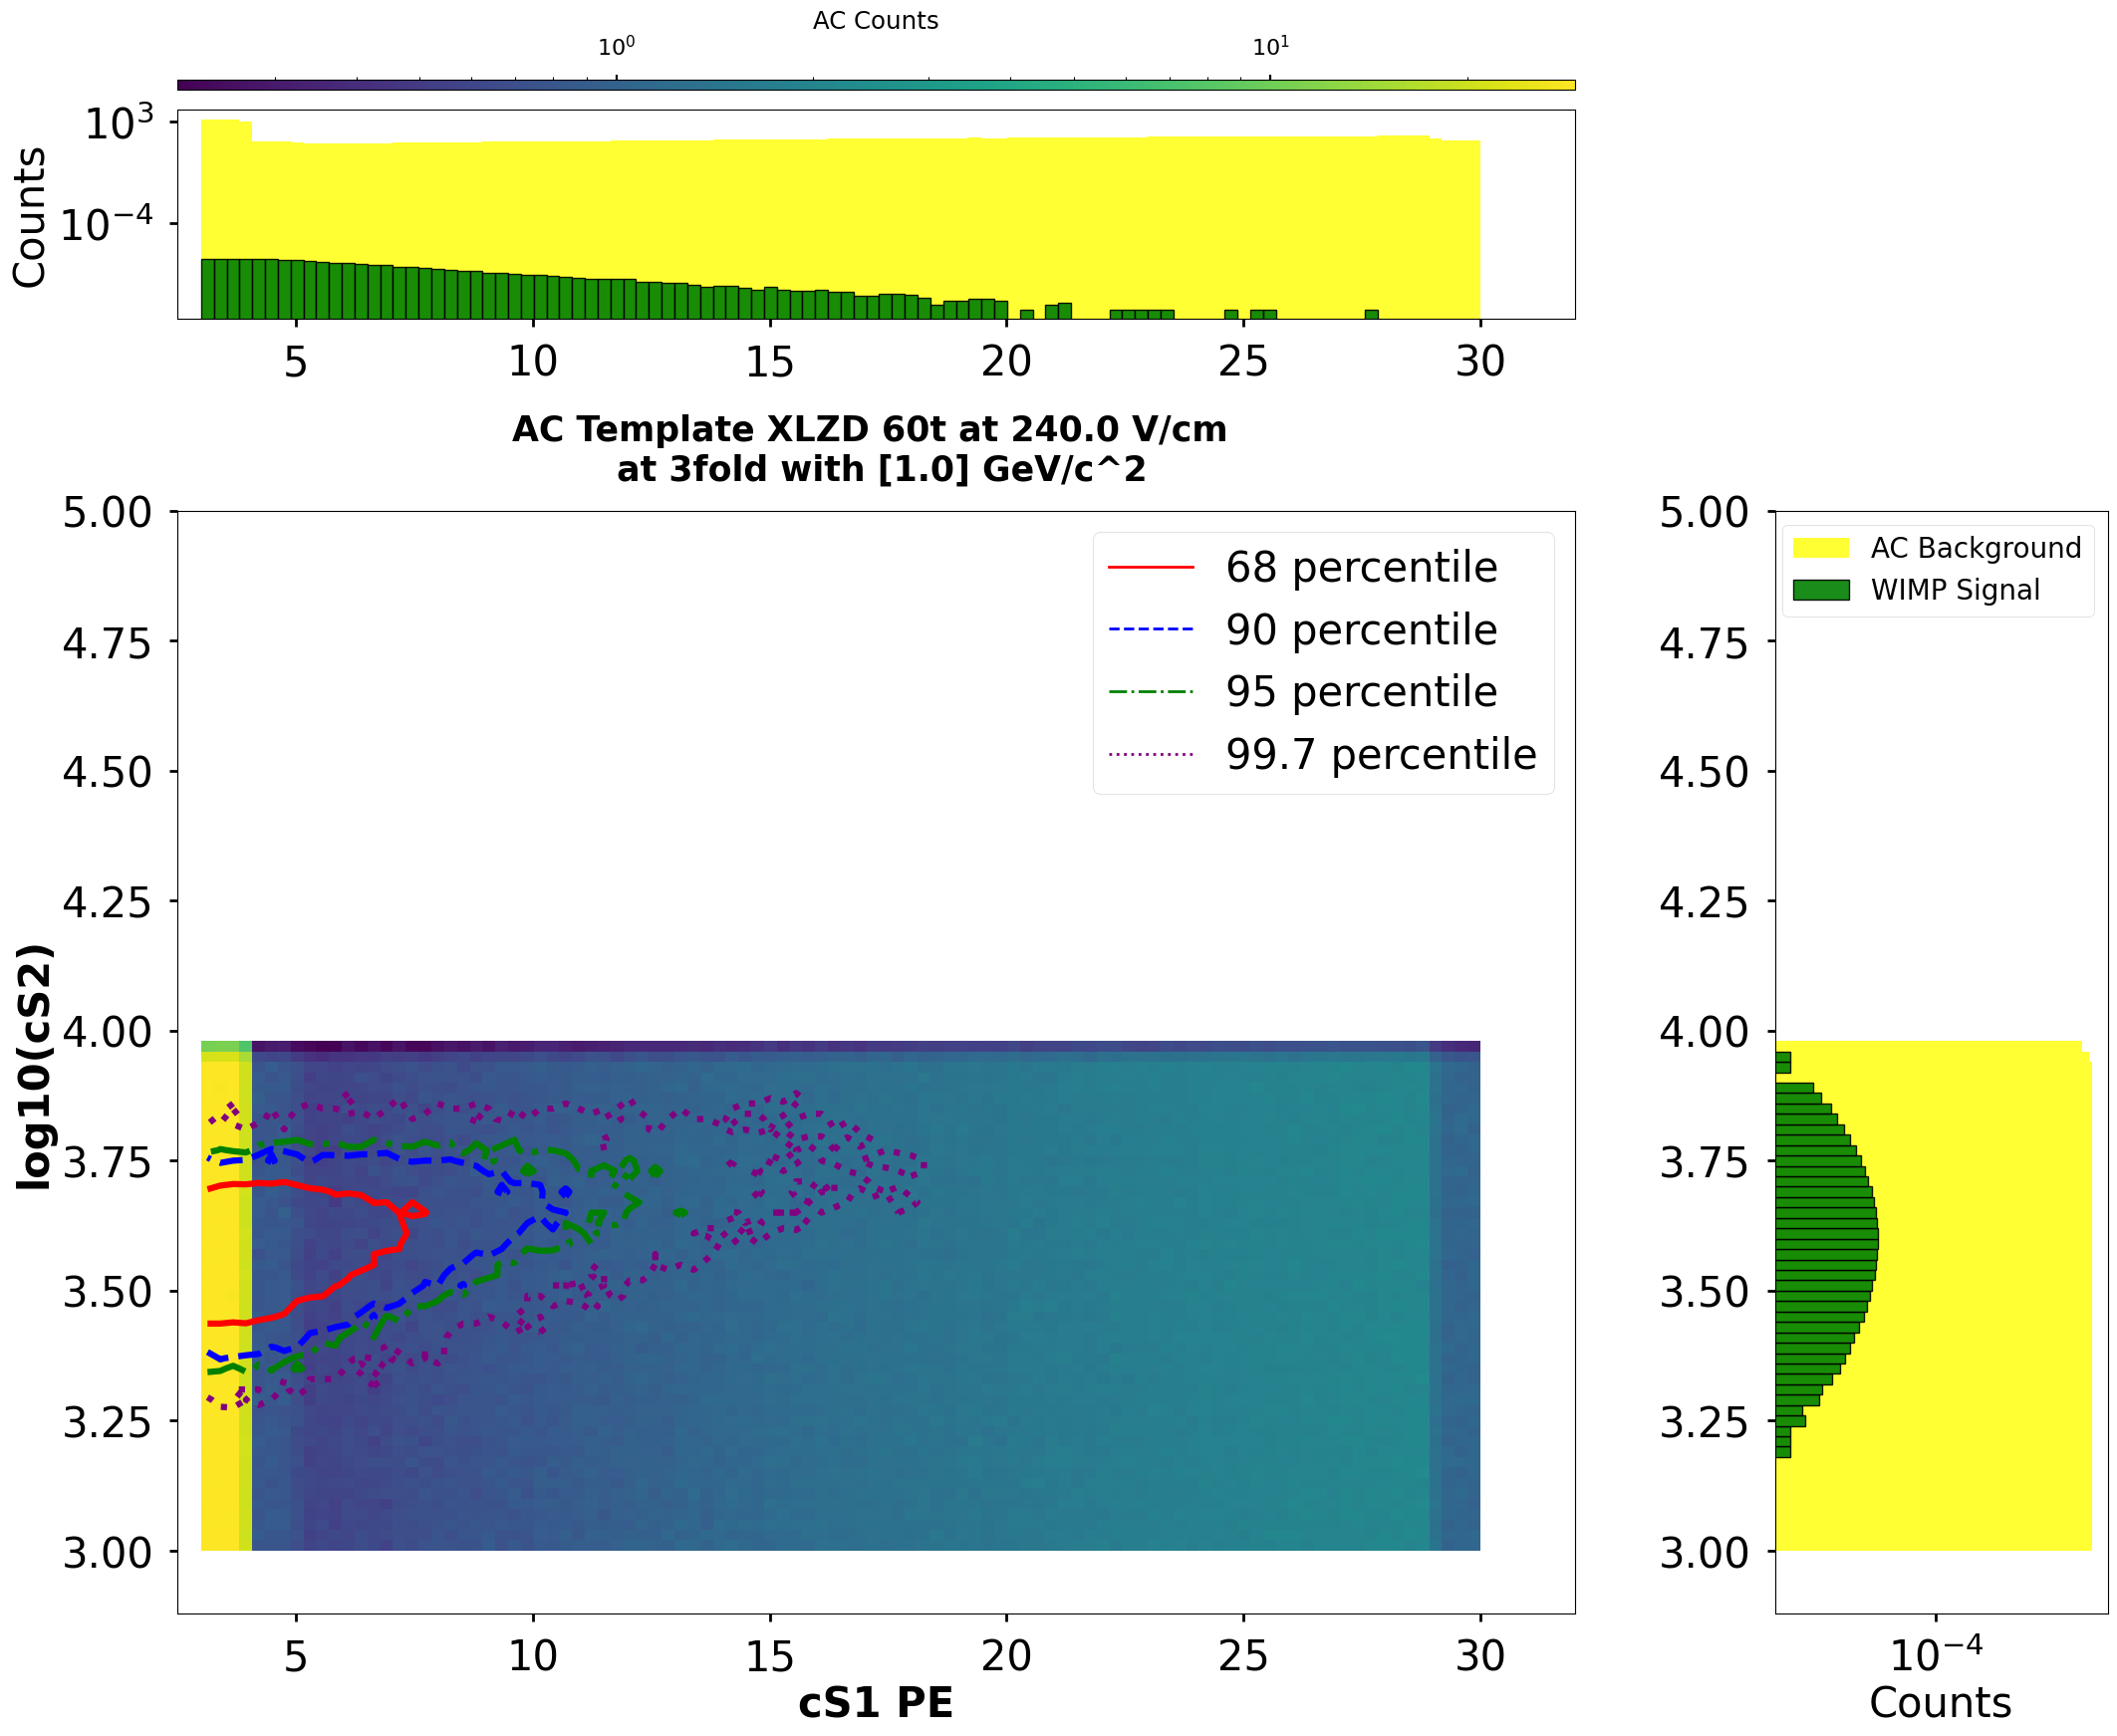

In [31]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get bin edges
print(AC_temp.n)
bin_edges_cS1 = AC_temp.bin_edges[0]
bin_edges_cS2 = AC_temp.bin_edges[1]

# Calculate bin centers
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2

# Get histogram counts for AC template (background)
counts_cS1_bg = AC_temp.histogram.sum(axis=1)  # Sum over log10(cS2)
counts_cS2_bg = AC_temp.histogram.sum(axis=0)  # Sum over cS1

# Get histogram counts for WIMP signal
counts_cS1_sig = Migdal_hist.histogram.sum(axis=1)  # Sum over log10(cS2)
counts_cS2_sig = Migdal_hist.histogram.sum(axis=0)  # Sum over cS1

# Main 2D histogram (AC template as background)
main_histogram_bg = AC_temp.histogram.T  # Background (transpose for alignment)
main_histogram_sig = Migdal_hist.histogram.T  # Signal



# Create figure with gridspec
plt.style.use('seaborn-v0_8-poster')
fig = plt.figure(figsize=(25, 20))
gs = fig.add_gridspec(4, 4, wspace=0.6, hspace=0.8)

# Main 2D histogram plot
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram_bg, cmap='viridis', norm=mcolors.LogNorm())
ax_main.set_xlabel('cS1 PE', fontsize=30, fontweight="bold")
ax_main.set_ylabel('log10(cS2)', fontsize=30, fontweight="bold")

# Correct way to format tick labels
ax_main.tick_params(axis='both', labelsize=30, width=2, length=6)
#fig.colorbar(pcm, ax=ax_main, label='AC Counts')
plt.title(f"AC Template XLZD {SolarER.configuration} at {SolarER.drift_field} V/cm \n at {extracted_text} with {masses} GeV/c^2", y=1.02, fontweight="bold",fontsize=25)

# Overlay WIMP signal as contour lines
# Define percentiles
percentiles = [68, 90, 95,99.7]
# Define different line styles and colors for each contour level
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']  
colors = ['red', 'blue', 'green', 'purple']  

# Compute contour levels from percentiles
contour_levels = [percentile_to_level(main_histogram_sig, p) for p in percentiles]
#contour_levels = sorted(contour_levels)
#print("Contour Levels:", contour_levels)


# Plot contours
# Plot contours with different colors
for i, level in enumerate(contour_levels):
    ax_main.contour(bin_centers_cS1, bin_centers_cS2, main_histogram_sig, 
                    levels=[level], colors=[colors[i]], linewidths=4.5, linestyles=line_styles[i], alpha=1.)




# Ensure we have enough styles/colors for the percentiles
num_levels = len(percentiles)
line_styles = (line_styles * (num_levels // len(line_styles) + 1))[:num_levels]
colors = (colors * (num_levels // len(colors) + 1))[:num_levels]

# Create legend handles with different styles
legend_handles = [
    plt.Line2D([], [], color=colors[i], linestyle=line_styles[i], linewidth=2, 
               label=f'{percentiles[i]} percentile') 
    for i in range(num_levels)
]

# Add legend to the plot
ax_main.legend(handles=legend_handles, loc='upper right',fontsize=30)



# Set limits
ax_main.set_xlim(2.50, 32)
ax_main.set_ylim(2.88, 5)

# **Top histogram (cS1 projection)**
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # Align with main plot
ax_top.bar(bin_centers_cS1, counts_cS1_bg, width=np.diff(bin_edges_cS1), 
           align='center', color='yellow', alpha=0.8, label='AC Background')

ax_top.bar(bin_centers_cS1, counts_cS1_sig, width=np.diff(bin_edges_cS1), 
           align='center', color='green', alpha=0.9, label='WIMP Signal', edgecolor='black', linewidth=1)

ax_top.set_yscale('log')  # Apply log scale
ax_top.set_ylabel('Counts',fontsize=30)
#ax_top.legend(loc="lower right")
ax_top.tick_params(labelbottom=True)  
ax_top.tick_params(axis='both', labelsize=30, width=2, length=6)

# **Add color bar above ax_top**
divider = make_axes_locatable(ax_top)
cax = divider.append_axes("top", size="5%", pad=0.2)
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', label='AC Counts')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")


# **Right histogram (cS2 projection)**
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)  # Align with main plot
ax_right.barh(bin_centers_cS2, counts_cS2_bg, height=np.diff(bin_edges_cS2), 
              align='center', color='yellow', alpha=0.8, label='AC Background')

ax_right.barh(bin_centers_cS2, counts_cS2_sig, height=np.diff(bin_edges_cS2), 
              align='center', color='green', alpha=0.9, label='WIMP Signal', edgecolor='black', linewidth=1)

ax_right.set_xscale('log')  # Apply log scale to x-axis
ax_right.set_xlabel('Counts',fontsize=30)
ax_right.legend(loc="upper right",fontsize=20)
ax_right.tick_params(labelleft=True)  # Hide y-axis labels (already shown on main plot)
ax_right.tick_params(axis='both', labelsize=30, width=2, length=6)
# Show plot
plt.show()



# Master Plot with All BGS + Signal, with 1D Projections

/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_9511/3482754840.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)


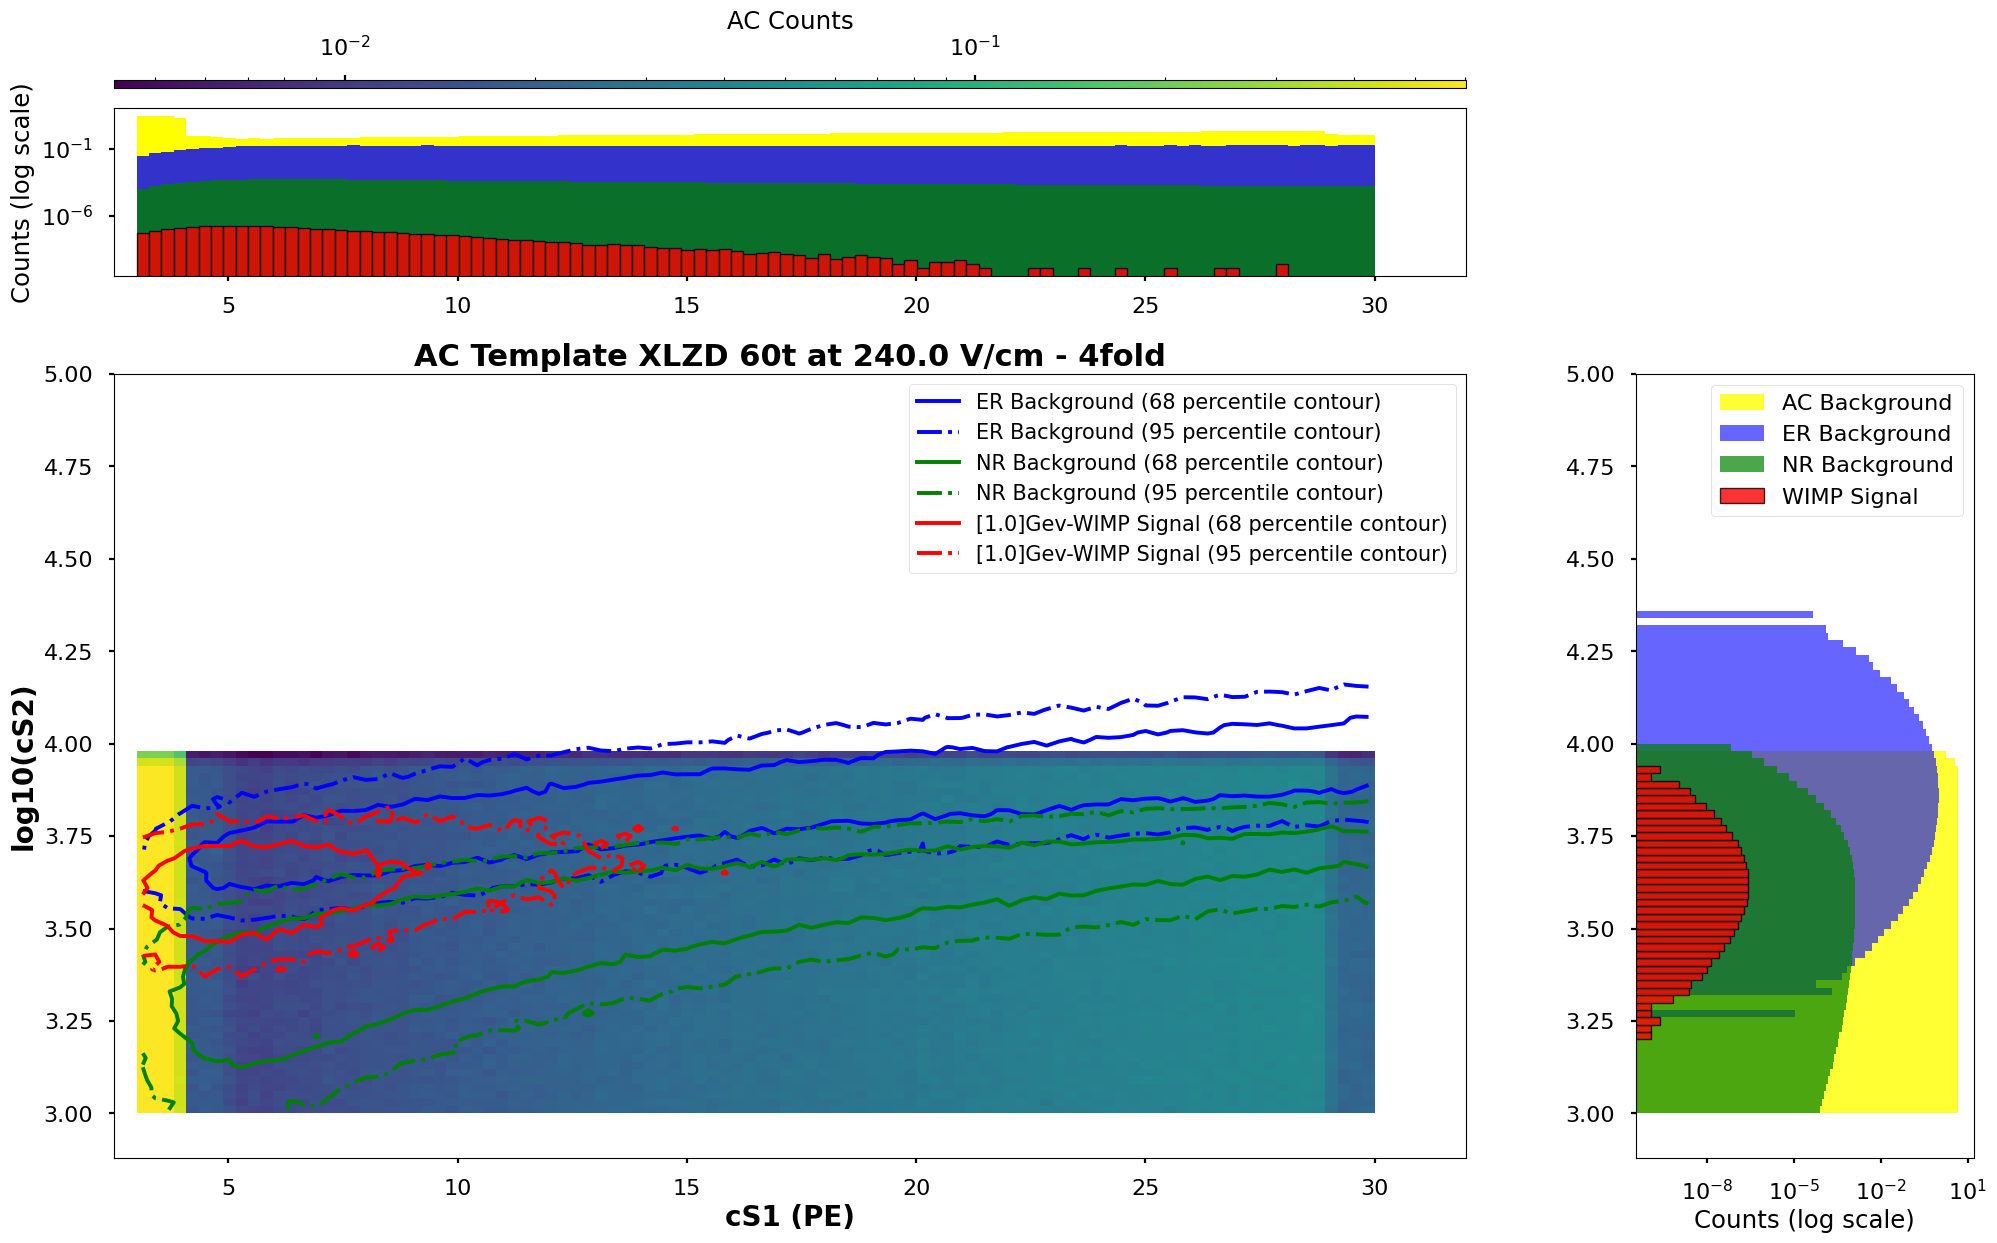

In [197]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get bin edges
bin_edges_cS1 = AC_temp.bin_edges[0]
bin_edges_cS2 = AC_temp.bin_edges[1]

# Calculate bin centers
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2


# Get histogram counts for 1D projections
counts_cS1_bg = AC_temp.histogram.sum(axis=1)  # Background projection over log10(cS2)
counts_cS2_bg = AC_temp.histogram.sum(axis=0)  # Background projection over cS1
counts_cS1_er = ER_hist.sum(axis=1)  # ER projection over log10(cS2)
counts_cS2_er = ER_hist.sum(axis=0)  # ER projection over cS1
counts_cS1_nr = NR_hist.sum(axis=1)  # NR projection over log10(cS2)
counts_cS2_nr = NR_hist.sum(axis=0)  # NR projection over cS1
counts_cS1_sig = Migdal_hist.histogram.sum(axis=1)  # WIMP projection over log10(cS2)
counts_cS2_sig = Migdal_hist.histogram.sum(axis=0)  # WIMP projection over cS1

# Transpose main histogram for alignment
main_histogram_bg = AC_temp.histogram.T  # AC background


# Create figure with gridspec
plt.style.use('seaborn-v0_8-poster')
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(4, 4, wspace=0.5, hspace=0.5)

# **Main 2D histogram plot**
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram_bg, cmap='viridis', norm=mcolors.LogNorm())
#fig.colorbar(pcm, ax=ax_main, label='AC Counts')

# Overlay ER, NR, and WIMP distributions **on the same plot**
er_handles = plot_hist_all(ER_hist, color="blue", label="ER Background")
nr_handles = plot_hist_all(NR_hist, color="green", label="NR Background")
wimp_handle = plot_hist_all(Migdal_hist, color="red", label=f"{masses}Gev-WIMP Signal",alpha=1.0,lw=15.5)

# Title and labels
ax_main.set_xlabel('cS1 (PE)', fontsize=20, fontweight="bold")
ax_main.set_ylabel('log10(cS2)', fontsize=20, fontweight="bold")
ax_main.set_xlim(2.50, 32)
ax_main.set_ylim(2.88, 5)
ax_main.set_title(f"AC Template XLZD {SolarER.configuration} at {SolarER.drift_field} V/cm - {extracted_text}",
                  fontweight="bold", fontsize=22)

# **Legend**
all_handles = er_handles + nr_handles + wimp_handle
ax_main.legend(handles=all_handles, loc='upper right', fontsize=15)

# **Top histogram (cS1 projection)**
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.bar(bin_centers_cS1, counts_cS1_bg, width=np.diff(bin_edges_cS1), align='center', color='yellow', alpha=1.0, label='AC Background')
ax_top.bar(bin_centers_cS1, counts_cS1_er, width=np.diff(bin_edges_cS1), align='center', color='blue', alpha=0.8, label='ER Background')
ax_top.bar(bin_centers_cS1, counts_cS1_nr, width=np.diff(bin_edges_cS1), align='center', color='green', alpha=0.8, label='NR Background')
ax_top.bar(bin_centers_cS1, counts_cS1_sig, width=np.diff(bin_edges_cS1), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_top.set_yscale('log')
ax_top.set_ylabel('Counts (log scale)')
#ax_top.legend(loc="lower right")
# **Add color bar above ax_top**
divider = make_axes_locatable(ax_top)
cax = divider.append_axes("top", size="5%", pad=0.2)
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', label='AC Counts')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

# **Right histogram (cS2 projection)**
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.barh(bin_centers_cS2, counts_cS2_bg, height=np.diff(bin_edges_cS2), align='center', color='yellow', alpha=0.8, label='AC Background')
ax_right.barh(bin_centers_cS2, counts_cS2_er, height=np.diff(bin_edges_cS2), align='center', color='blue', alpha=0.6, label='ER Background')
ax_right.barh(bin_centers_cS2, counts_cS2_nr, height=np.diff(bin_edges_cS2), align='center', color='green', alpha=0.7, label='NR Background')
ax_right.barh(bin_centers_cS2, counts_cS2_sig, height=np.diff(bin_edges_cS2), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_right.set_xscale('log')
ax_right.set_xlabel('Counts (log scale)')
ax_right.legend(loc="upper right")

# Show plot
plt.show()

# PLotting only the 95 percentile contours

/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_9511/466445196.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)


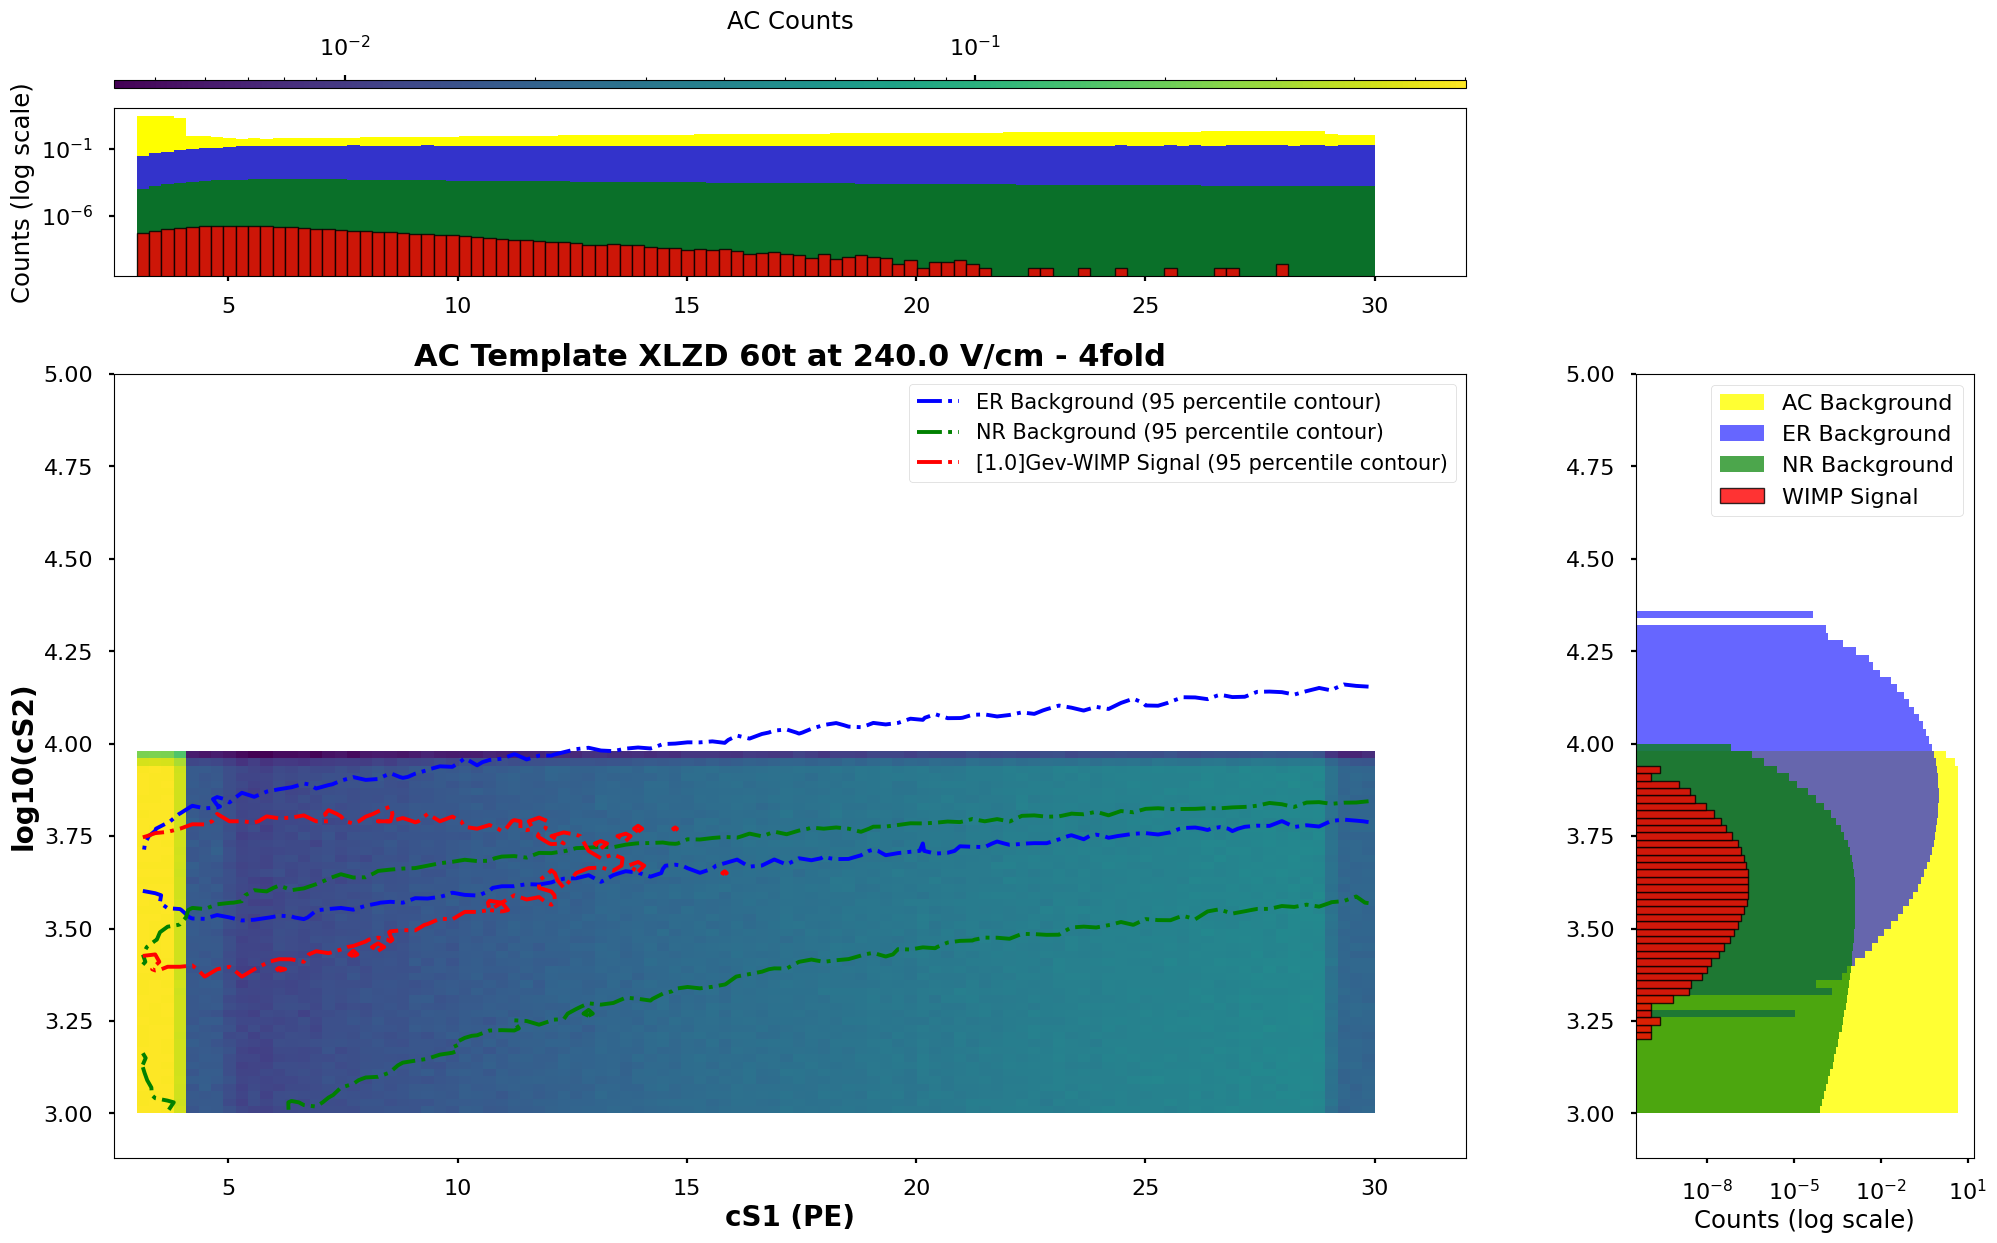

In [198]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get bin edges
bin_edges_cS1 = AC_temp.bin_edges[0]
bin_edges_cS2 = AC_temp.bin_edges[1]

# Calculate bin centers
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2


# Get histogram counts for 1D projections
counts_cS1_bg = AC_temp.histogram.sum(axis=1)  # Background projection over log10(cS2)
counts_cS2_bg = AC_temp.histogram.sum(axis=0)  # Background projection over cS1
counts_cS1_er = ER_hist.sum(axis=1)  # ER projection over log10(cS2)
counts_cS2_er = ER_hist.sum(axis=0)  # ER projection over cS1
counts_cS1_nr = NR_hist.sum(axis=1)  # NR projection over log10(cS2)
counts_cS2_nr = NR_hist.sum(axis=0)  # NR projection over cS1
counts_cS1_sig = Migdal_hist.histogram.sum(axis=1)  # WIMP projection over log10(cS2)
counts_cS2_sig = Migdal_hist.histogram.sum(axis=0)  # WIMP projection over cS1

# Transpose main histogram for alignment
main_histogram_bg = AC_temp.histogram.T  # AC background


# Create figure with gridspec
plt.style.use('seaborn-v0_8-poster')
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(4, 4, wspace=0.5, hspace=0.5)

# **Main 2D histogram plot**
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram_bg, cmap='viridis', norm=mcolors.LogNorm())
#fig.colorbar(pcm, ax=ax_main, label='AC Counts')

# Overlay ER, NR, and WIMP distributions **on the same plot**
er_handles = plot_hist_95(ER_hist, color="blue", label="ER Background")
nr_handles = plot_hist_95(NR_hist, color="green", label="NR Background")
wimp_handle = plot_hist_95(Migdal_hist, color="red", label=f"{masses}Gev-WIMP Signal",alpha=1.0,lw=15.5)

# Title and labels
ax_main.set_xlabel('cS1 (PE)', fontsize=20, fontweight="bold")
ax_main.set_ylabel('log10(cS2)', fontsize=20, fontweight="bold")
ax_main.set_xlim(2.50, 32)
ax_main.set_ylim(2.88, 5)
ax_main.set_title(f"AC Template XLZD {SolarER.configuration} at {SolarER.drift_field} V/cm - {extracted_text}",
                  fontweight="bold", fontsize=22)

# **Legend**
all_handles = er_handles + nr_handles + wimp_handle
ax_main.legend(handles=all_handles, loc='upper right', fontsize=15)

# **Top histogram (cS1 projection)**
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.bar(bin_centers_cS1, counts_cS1_bg, width=np.diff(bin_edges_cS1), align='center', color='yellow', alpha=1.0, label='AC Background')
ax_top.bar(bin_centers_cS1, counts_cS1_er, width=np.diff(bin_edges_cS1), align='center', color='blue', alpha=0.8, label='ER Background')
ax_top.bar(bin_centers_cS1, counts_cS1_nr, width=np.diff(bin_edges_cS1), align='center', color='green', alpha=0.8, label='NR Background')
ax_top.bar(bin_centers_cS1, counts_cS1_sig, width=np.diff(bin_edges_cS1), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_top.set_yscale('log')
ax_top.set_ylabel('Counts (log scale)')
#ax_top.legend(loc="lower right")
# **Add color bar above ax_top**
divider = make_axes_locatable(ax_top)
cax = divider.append_axes("top", size="5%", pad=0.2)
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', label='AC Counts')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

# **Right histogram (cS2 projection)**
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.barh(bin_centers_cS2, counts_cS2_bg, height=np.diff(bin_edges_cS2), align='center', color='yellow', alpha=0.8, label='AC Background')
ax_right.barh(bin_centers_cS2, counts_cS2_er, height=np.diff(bin_edges_cS2), align='center', color='blue', alpha=0.6, label='ER Background')
ax_right.barh(bin_centers_cS2, counts_cS2_nr, height=np.diff(bin_edges_cS2), align='center', color='green', alpha=0.7, label='NR Background')
ax_right.barh(bin_centers_cS2, counts_cS2_sig, height=np.diff(bin_edges_cS2), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_right.set_xscale('log')
ax_right.set_xlabel('Counts (log scale)')
ax_right.legend(loc="upper right")

# Show plot
plt.show()

# Plotting the 68 percentile contours only

/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_9511/4171259928.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  c = plt.contour(xx, yy, zz, levels=[level], colors=[color], linestyles=[ls], **kwargs)


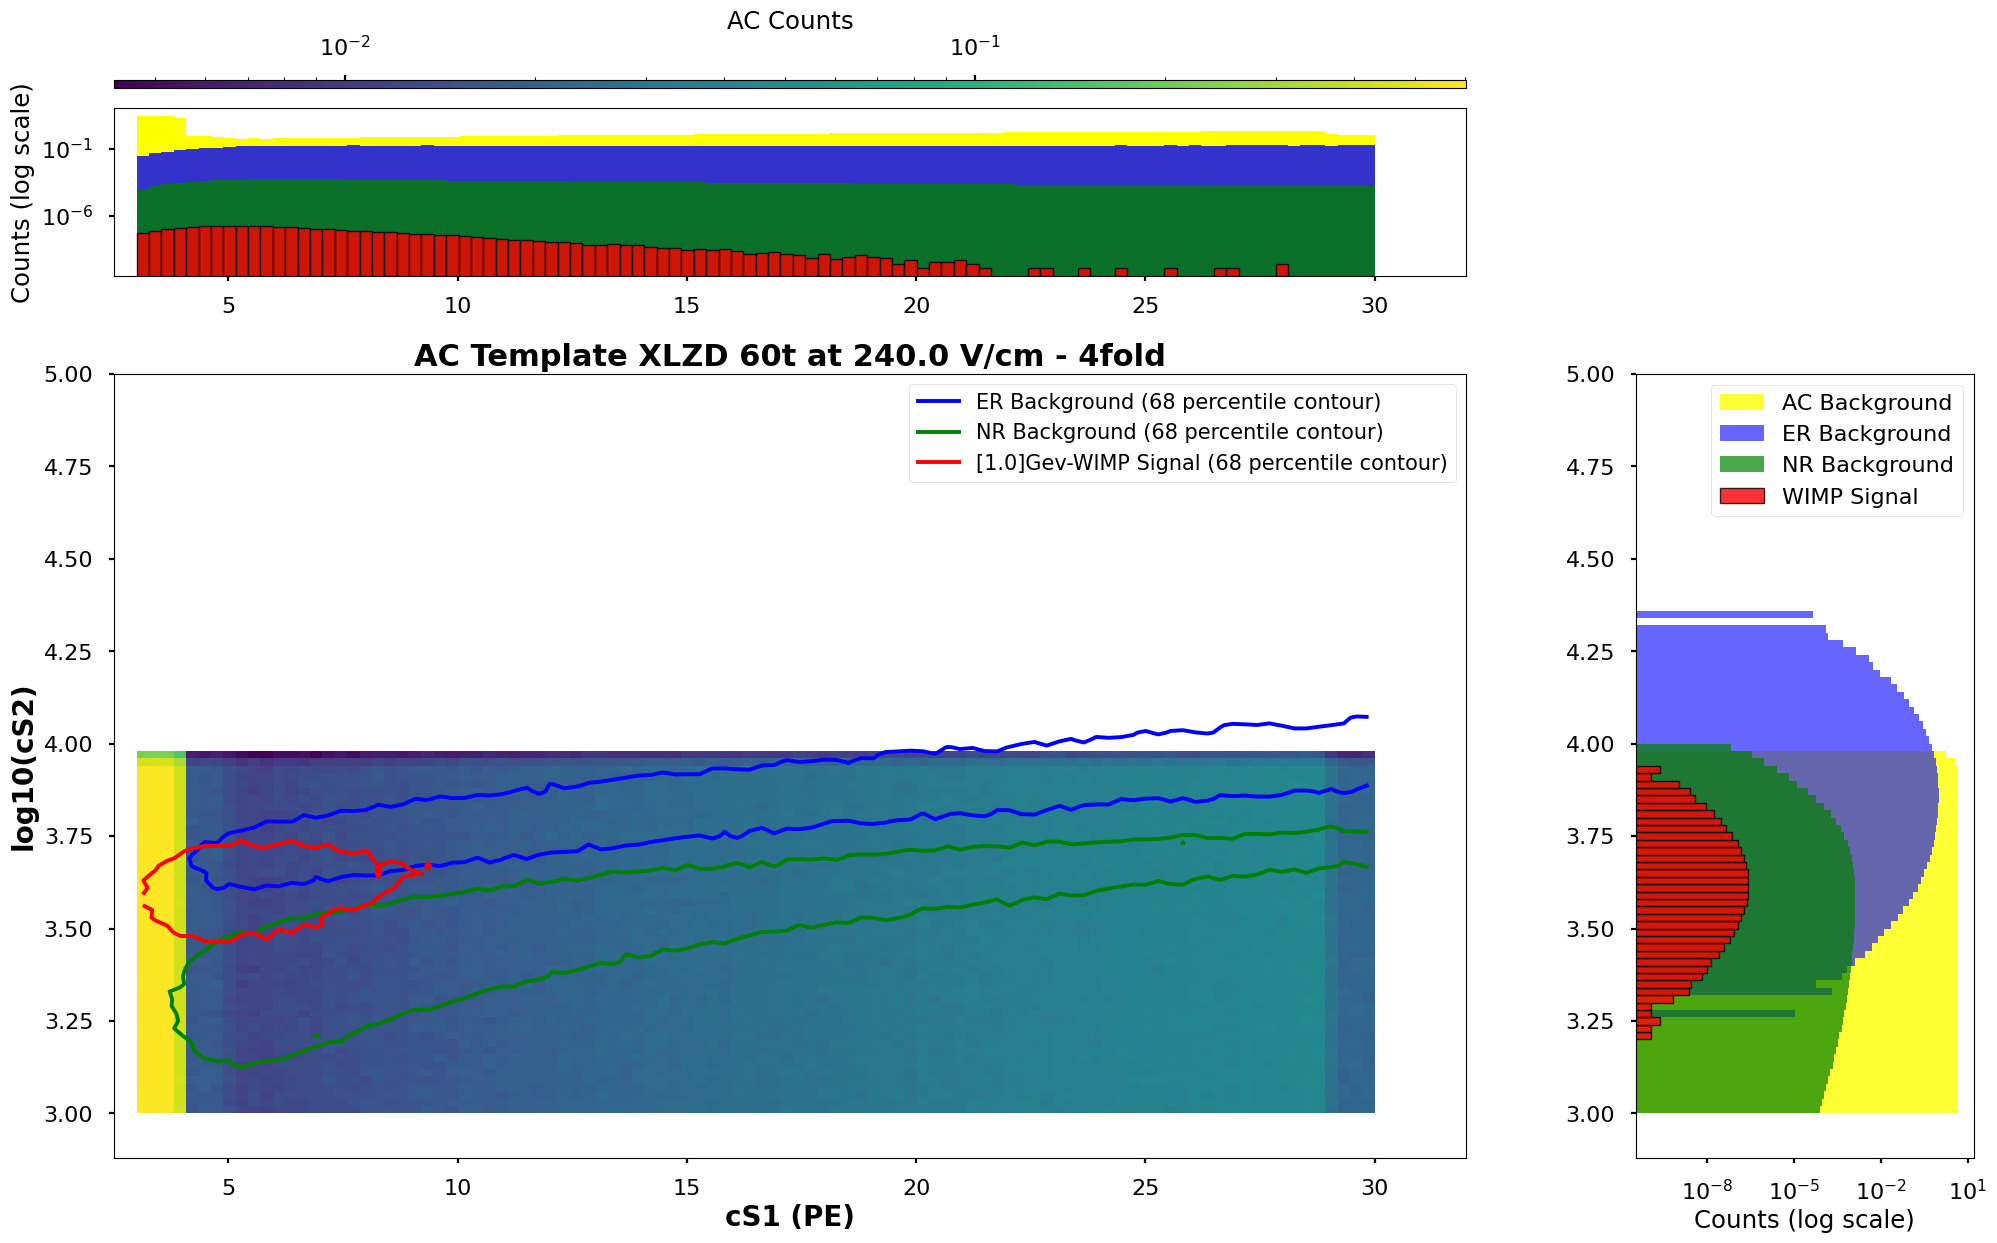

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get bin edges
bin_edges_cS1 = AC_temp.bin_edges[0]
bin_edges_cS2 = AC_temp.bin_edges[1]

# Calculate bin centers
bin_centers_cS1 = (bin_edges_cS1[:-1] + bin_edges_cS1[1:]) / 2
bin_centers_cS2 = (bin_edges_cS2[:-1] + bin_edges_cS2[1:]) / 2


# Get histogram counts for 1D projections
counts_cS1_bg = AC_temp.histogram.sum(axis=1)  # Background projection over log10(cS2)
counts_cS2_bg = AC_temp.histogram.sum(axis=0)  # Background projection over cS1
counts_cS1_er = ER_hist.sum(axis=1)  # ER projection over log10(cS2)
counts_cS2_er = ER_hist.sum(axis=0)  # ER projection over cS1
counts_cS1_nr = NR_hist.sum(axis=1)  # NR projection over log10(cS2)
counts_cS2_nr = NR_hist.sum(axis=0)  # NR projection over cS1
counts_cS1_sig = Migdal_hist.histogram.sum(axis=1)  # WIMP projection over log10(cS2)
counts_cS2_sig = Migdal_hist.histogram.sum(axis=0)  # WIMP projection over cS1

# Transpose main histogram for alignment
main_histogram_bg = AC_temp.histogram.T  # AC background


# Create figure with gridspec
plt.style.use('seaborn-v0_8-poster')
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(4, 4, wspace=0.5, hspace=0.5)

# **Main 2D histogram plot**
ax_main = fig.add_subplot(gs[1:, :-1])
pcm = ax_main.pcolormesh(bin_edges_cS1, bin_edges_cS2, main_histogram_bg, cmap='viridis', norm=mcolors.LogNorm())
#fig.colorbar(pcm, ax=ax_main, label='AC Counts')

# Overlay ER, NR, and WIMP distributions **on the same plot**
er_handles = plot_hist_68(ER_hist, color="blue", label="ER Background")
nr_handles = plot_hist_68(NR_hist, color="green", label="NR Background")
wimp_handle = plot_hist_68(Migdal_hist, color="red", label=f"{masses}Gev-WIMP Signal",alpha=1.0,lw=15.5)

# Title and labels
ax_main.set_xlabel('cS1 (PE)', fontsize=20, fontweight="bold")
ax_main.set_ylabel('log10(cS2)', fontsize=20, fontweight="bold")
ax_main.set_xlim(2.50, 32)
ax_main.set_ylim(2.88, 5)
ax_main.set_title(f"AC Template XLZD {SolarER.configuration} at {SolarER.drift_field} V/cm - {extracted_text}",
                  fontweight="bold", fontsize=22)

# **Legend**
all_handles = er_handles + nr_handles + wimp_handle
ax_main.legend(handles=all_handles, loc='upper right', fontsize=15)

# **Top histogram (cS1 projection)**
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.bar(bin_centers_cS1, counts_cS1_bg, width=np.diff(bin_edges_cS1), align='center', color='yellow', alpha=1.0, label='AC Background')
ax_top.bar(bin_centers_cS1, counts_cS1_er, width=np.diff(bin_edges_cS1), align='center', color='blue', alpha=0.8, label='ER Background')
ax_top.bar(bin_centers_cS1, counts_cS1_nr, width=np.diff(bin_edges_cS1), align='center', color='green', alpha=0.8, label='NR Background')
ax_top.bar(bin_centers_cS1, counts_cS1_sig, width=np.diff(bin_edges_cS1), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_top.set_yscale('log')
ax_top.set_ylabel('Counts (log scale)')
#ax_top.legend(loc="lower right")
# **Add color bar above ax_top**
divider = make_axes_locatable(ax_top)
cax = divider.append_axes("top", size="5%", pad=0.2)
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', label='AC Counts')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

# **Right histogram (cS2 projection)**
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.barh(bin_centers_cS2, counts_cS2_bg, height=np.diff(bin_edges_cS2), align='center', color='yellow', alpha=0.8, label='AC Background')
ax_right.barh(bin_centers_cS2, counts_cS2_er, height=np.diff(bin_edges_cS2), align='center', color='blue', alpha=0.6, label='ER Background')
ax_right.barh(bin_centers_cS2, counts_cS2_nr, height=np.diff(bin_edges_cS2), align='center', color='green', alpha=0.7, label='NR Background')
ax_right.barh(bin_centers_cS2, counts_cS2_sig, height=np.diff(bin_edges_cS2), align='center', color='red', alpha=0.8, label='WIMP Signal', edgecolor='black', linewidth=1)
ax_right.set_xscale('log')
ax_right.set_xlabel('Counts (log scale)')
ax_right.legend(loc="upper right")

# Show plot
plt.show()